In [32]:
%pip install pandas
%pip install matplotlib
%pip install seaborn
%pip install scikit-learn
%pip install nltk
%pip install wordcloud
%pip install emoji

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
df = pd.read_csv("scitweets_export.tsv", sep="\t")
df.head()

,Unnamed: 0,tweet_id,text,science_related,scientific_claim,scientific_reference,scientific_context
0,0,316669998137483264,Knees are a bit sore. i guess that's a sign th...,0,0.0,0.0,0.0
1,1,319090866545385472,McDonald's breakfast stop then the gym 🏀💪,0,0.0,0.0,0.0
2,2,322030931022065664,Can any Gynecologist with Cancer Experience ex...,1,1.0,0.0,0.0
3,3,322694830620807168,Couch-lock highs lead to sleeping in the couch...,1,1.0,0.0,0.0
4,4,328524426658328576,Does daily routine help prevent problems with ...,1,1.0,0.0,0.0


In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_all = vectorizer.fit_transform(df['text'])

Count Vectorizer Features: (1140, 5000)
TF-IDF Vectorizer Features: (1140, 693)
TF-IDF on Preprocessed Text Features: (1140, 5000)


/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values b


Features after Chi-squared selection: (1140, 100)
Features after Mutual Information selection: (1140, 100)


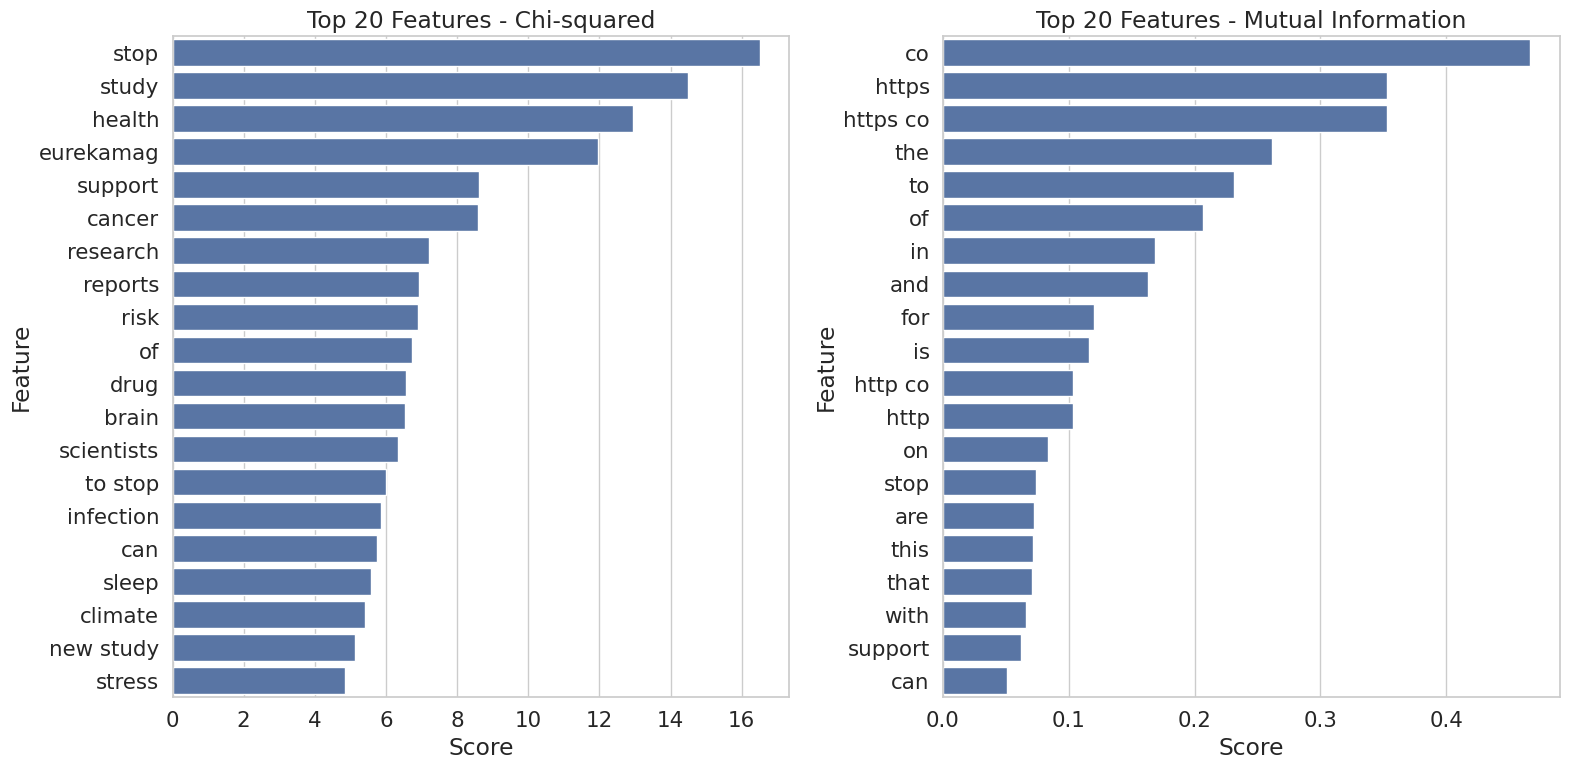

In [35]:
# Compare different feature extraction methods
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Create label for Task 1
y_task1 = df['science_related']

# 1. Count Vectorizer
count_vec = CountVectorizer(max_features=5000)
X_count = count_vec.fit_transform(df['text'])

# 2. TF-IDF with more parameters
tfidf_vec = TfidfVectorizer(max_features=5000, 
                           min_df=5, 
                           max_df=0.8, 
                           ngram_range=(1, 2))
X_tfidf = tfidf_vec.fit_transform(df['text'])

# 3. TF-IDF with preprocessing already done
tfidf_processed = TfidfVectorizer(max_features=5000)
X_tfidf_processed = tfidf_processed.fit_transform(df['text'])

# Compare feature extraction methods
print(f"Count Vectorizer Features: {X_count.shape}")
print(f"TF-IDF Vectorizer Features: {X_tfidf.shape}")
print(f"TF-IDF on Preprocessed Text Features: {X_tfidf_processed.shape}")

# Feature selection using Chi-squared
selector_chi2 = SelectKBest(chi2, k=100)
X_chi2 = selector_chi2.fit_transform(X_tfidf, y_task1)

# Feature selection using Mutual Information
selector_mi = SelectKBest(mutual_info_classif, k=100)
X_mi = selector_mi.fit_transform(X_tfidf, y_task1)

print(f"\nFeatures after Chi-squared selection: {X_chi2.shape}")
print(f"Features after Mutual Information selection: {X_mi.shape}")

# Get and visualize the most important features
chi2_selected_indices = selector_chi2.get_support(indices=True)
mi_selected_indices = selector_mi.get_support(indices=True)

chi2_feature_names = np.array(tfidf_vec.get_feature_names_out())[chi2_selected_indices]
mi_feature_names = np.array(tfidf_vec.get_feature_names_out())[mi_selected_indices]

# Plot top 20 features by importance
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
chi2_scores = selector_chi2.scores_[chi2_selected_indices]
chi2_features_df = pd.DataFrame({'Feature': chi2_feature_names, 'Score': chi2_scores})
chi2_features_df = chi2_features_df.sort_values('Score', ascending=False).head(20)
sns.barplot(x='Score', y='Feature', data=chi2_features_df)
plt.title('Top 20 Features - Chi-squared')

plt.subplot(1, 2, 2)
mi_scores = selector_mi.scores_[mi_selected_indices]
mi_features_df = pd.DataFrame({'Feature': mi_feature_names, 'Score': mi_scores})
mi_features_df = mi_features_df.sort_values('Score', ascending=False).head(20)
sns.barplot(x='Score', y='Feature', data=mi_features_df)
plt.title('Top 20 Features - Mutual Information')

plt.tight_layout()
plt.show()

# We'll use the TF-IDF on preprocessed text for subsequent modeling
X_selected = X_tfidf

In [36]:
# Create labels for all tasks
df['task1_label'] = df['science_related']

df_sci = df[df['science_related'] == 1].copy()
df_sci['task2_label'] = ((df_sci['scientific_claim'] == 1.0) | (df_sci['scientific_reference'] == 1.0)).astype(int)
df_sci['task3_label'] = df_sci[['scientific_claim', 'scientific_reference', 'scientific_context']].idxmax(axis=1)
df_sci['task3_label'] = df_sci['task3_label'].map({
    'scientific_claim': 0,
    'scientific_reference': 1,
    'scientific_context': 2
})

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

# Get a dense version of our features for Gaussian NB
X_dense = X_selected.toarray()

# Split data for Task 1
X_train_task1, X_test_task1, y_train_task1, y_test_task1 = train_test_split(
    X_dense, df['task1_label'], test_size=0.2, random_state=42
)

# Compare different NB variants for Task 1
nb_models = {
    'Gaussian NB': GaussianNB(),
    'Multinomial NB': MultinomialNB(),
    'Complement NB': ComplementNB(),
    'Bernoulli NB': BernoulliNB(),
    'KNN'   : KNeighborsClassifier(n_neighbors=5),
    'SVM'   : SVC(kernel='linear', C=1),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100),
}

task1_results = {}
print("Task 1: Science Related Classification\n" + "="*40)
for name, model in nb_models.items():
    task1_results[name] = evaluate_model(
        model, X_train_task1, X_test_task1, y_train_task1, y_test_task1, name
    )
    print("\n")

Task 1: Science Related Classification
Model: Gaussian NB
Accuracy: 0.6711
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       146
           1       0.53      0.70      0.60        82

    accuracy                           0.67       228
   macro avg       0.66      0.68      0.66       228
weighted avg       0.70      0.67      0.68       228



Model: Multinomial NB
Accuracy: 0.7544
              precision    recall  f1-score   support

           0       0.74      0.96      0.83       146
           1       0.84      0.39      0.53        82

    accuracy                           0.75       228
   macro avg       0.79      0.67      0.68       228
weighted avg       0.77      0.75      0.73       228



Model: Complement NB
Accuracy: 0.7851
              precision    recall  f1-score   support

           0       0.84      0.82      0.83       146
           1       0.69      0.73      0.71        82

    accuracy              

Performing 10-fold cross-validation for Gaussian NB...
  Average: Accuracy=0.6728 ± 0.0245
  Average: F1 Score=0.6090 ± 0.0290

Performing 10-fold cross-validation for Multinomial NB...
  Average: Accuracy=0.7868 ± 0.0232
  Average: F1 Score=0.5587 ± 0.0653

Performing 10-fold cross-validation for Complement NB...
  Average: Accuracy=0.7772 ± 0.0229
  Average: F1 Score=0.6921 ± 0.0204

Performing 10-fold cross-validation for Bernoulli NB...
  Average: Accuracy=0.7982 ± 0.0215
  Average: F1 Score=0.6795 ± 0.0355

Performing 10-fold cross-validation for KNN...
  Average: Accuracy=0.7114 ± 0.0367
  Average: F1 Score=0.5443 ± 0.0647

Performing 10-fold cross-validation for SVM...
  Average: Accuracy=0.7930 ± 0.0319
  Average: F1 Score=0.6562 ± 0.0459

Performing 10-fold cross-validation for Logistic Regression...
  Average: Accuracy=0.7904 ± 0.0262
  Average: F1 Score=0.5900 ± 0.0711

Performing 10-fold cross-validation for Random Forest...
  Average: Accuracy=0.7807 ± 0.0218
  Average: F1

/tmp/ipykernel_368067/4283035198.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


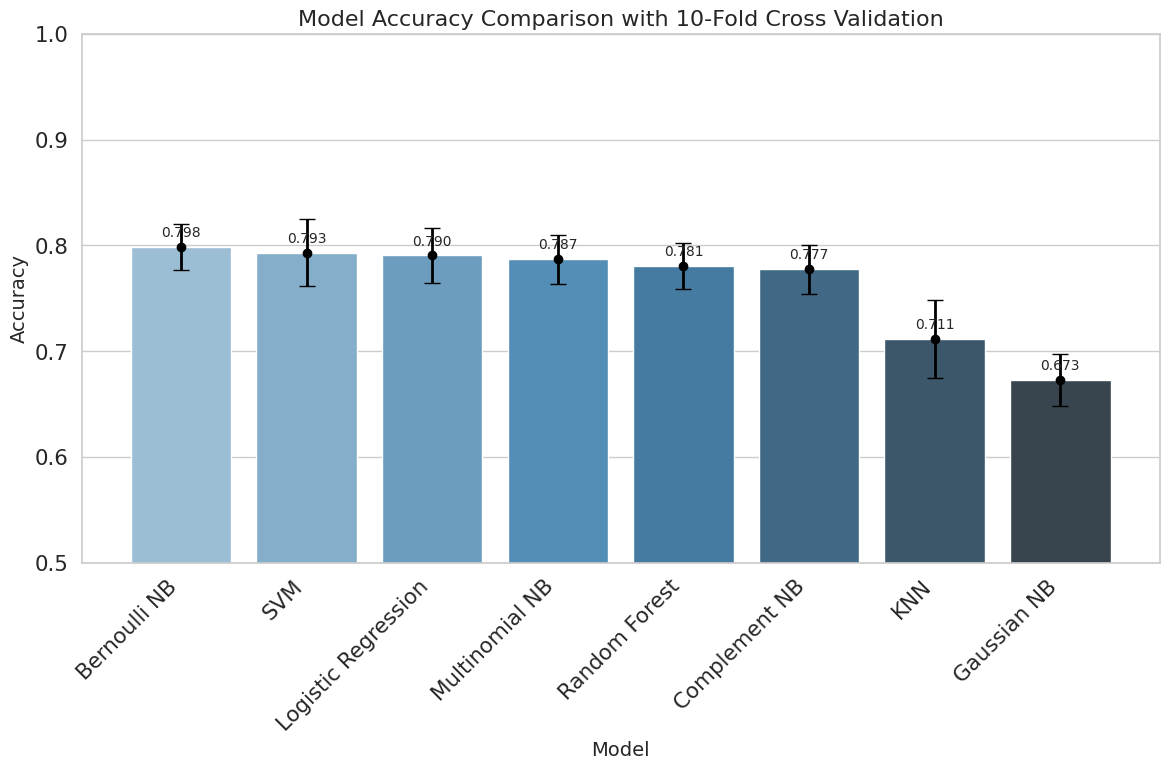

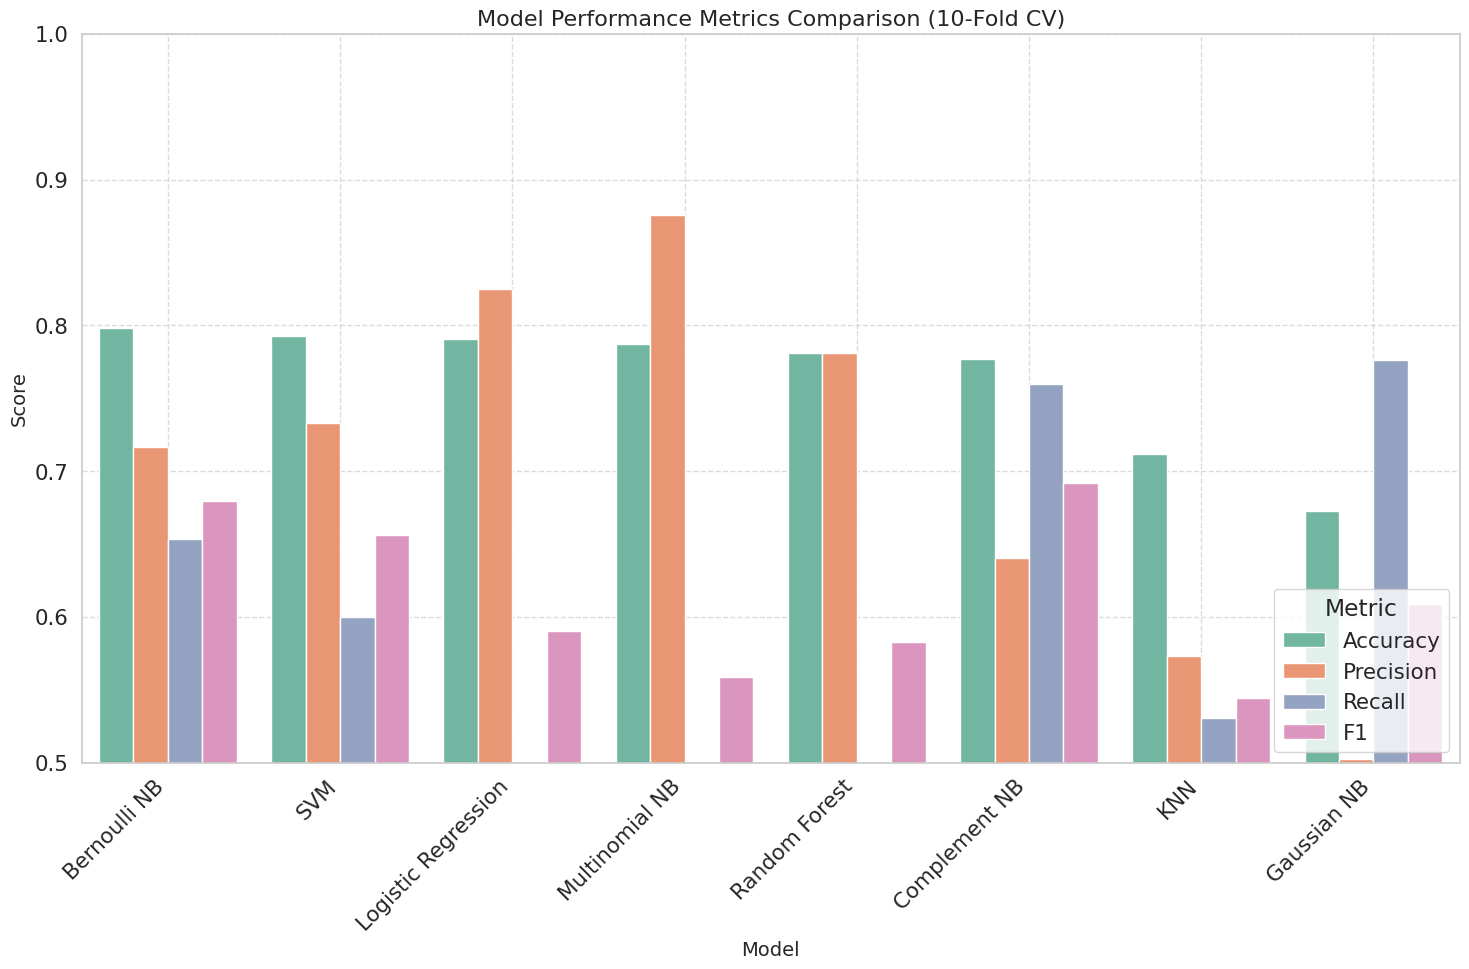

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize k-fold cross validation
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Dictionary to store results
cv_results = {}

# Perform k-fold cross validation for each model
for model_name, model in nb_models.items():
    print(f"Performing {k_folds}-fold cross-validation for {model_name}...")
    
    # Initialize lists to store performance metrics for each fold
    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    
    # For each fold
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_dense, y_task1)):
        # Split data
        X_train_fold, X_test_fold = X_dense[train_idx], X_dense[test_idx]
        y_train_fold, y_test_fold = y_task1.iloc[train_idx], y_task1.iloc[test_idx]
        
        # Train model
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate metrics
        acc = accuracy_score(y_test_fold, y_pred_fold)
        prec = precision_score(y_test_fold, y_pred_fold, zero_division=0)
        rec = recall_score(y_test_fold, y_pred_fold, zero_division=0)
        f1 = f1_score(y_test_fold, y_pred_fold, zero_division=0)
        
        fold_accuracy.append(acc)
        fold_precision.append(prec)
        fold_recall.append(rec)
        fold_f1.append(f1)
    
    # Store average metrics and standard deviations
    cv_results[model_name] = {
        'accuracy': {
            'mean': np.mean(fold_accuracy),
            'std': np.std(fold_accuracy)
        },
        'precision': {
            'mean': np.mean(fold_precision),
            'std': np.std(fold_precision)
        },
        'recall': {
            'mean': np.mean(fold_recall),
            'std': np.std(fold_recall)
        },
        'f1': {
            'mean': np.mean(fold_f1),
            'std': np.std(fold_f1)
        }
    }
    
    print(f"  Average: Accuracy={cv_results[model_name]['accuracy']['mean']:.4f} ± {cv_results[model_name]['accuracy']['std']:.4f}")
    print(f"  Average: F1 Score={cv_results[model_name]['f1']['mean']:.4f} ± {cv_results[model_name]['f1']['std']:.4f}")
    print()

# Create DataFrame for visualization
results_df = pd.DataFrame({
    'Model': [],
    'Metric': [],
    'Mean': [],
    'Std': []
})

for model_name in cv_results:
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        results_df = pd.concat([results_df, pd.DataFrame({
            'Model': [model_name],
            'Metric': [metric.capitalize()],
            'Mean': [cv_results[model_name][metric]['mean']],
            'Std': [cv_results[model_name][metric]['std']]
        })], ignore_index=True)

# Sort models by accuracy
model_order = results_df[results_df['Metric'] == 'Accuracy'].sort_values('Mean', ascending=False)['Model'].tolist()

# Create plots
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create bar plot for accuracy
ax = sns.barplot(
    data=results_df[results_df['Metric'] == 'Accuracy'],
    x='Model',
    y='Mean',
    order=model_order,
    palette='Blues_d'
)

# Add error bars
for i, model in enumerate(model_order):
    row = results_df[(results_df['Model'] == model) & (results_df['Metric'] == 'Accuracy')].iloc[0]
    ax.errorbar(
        i, row['Mean'], yerr=row['Std'],
        fmt='o', color='black', elinewidth=2, capsize=6
    )

# Add value labels on top of bars
for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.3f}",
        ha='center',
        fontsize=10
    )

plt.title(f'Model Accuracy Comparison with {k_folds}-Fold Cross Validation', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

# Create a grouped bar chart for all metrics
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Create grouped bar plot
ax = sns.barplot(
    data=results_df,
    x='Model',
    y='Mean',
    hue='Metric',
    order=model_order,
    palette='Set2'
)

plt.title(f'Model Performance Metrics Comparison ({k_folds}-Fold CV)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='lower right')
plt.ylim([0.5, 1.0])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Parameter optimization

Performing Grid Search for Gaussian NB...
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Best Parameters: {'var_smoothing': np.float64(0.01519911082952933)}
Best Cross-Validation Score: 0.7500
Test Accuracy with Best Parameters: 0.7325


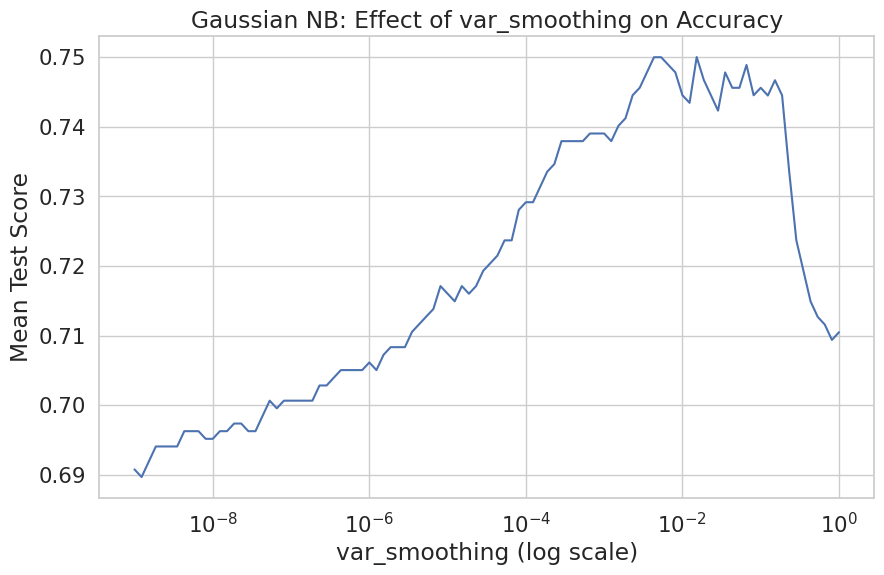

Performing Grid Search for Multinomial NB...
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best Parameters: {'alpha': np.float64(0.4641588833612782), 'fit_prior': True}
Best Cross-Validation Score: 0.8093
Test Accuracy with Best Parameters: 0.7982


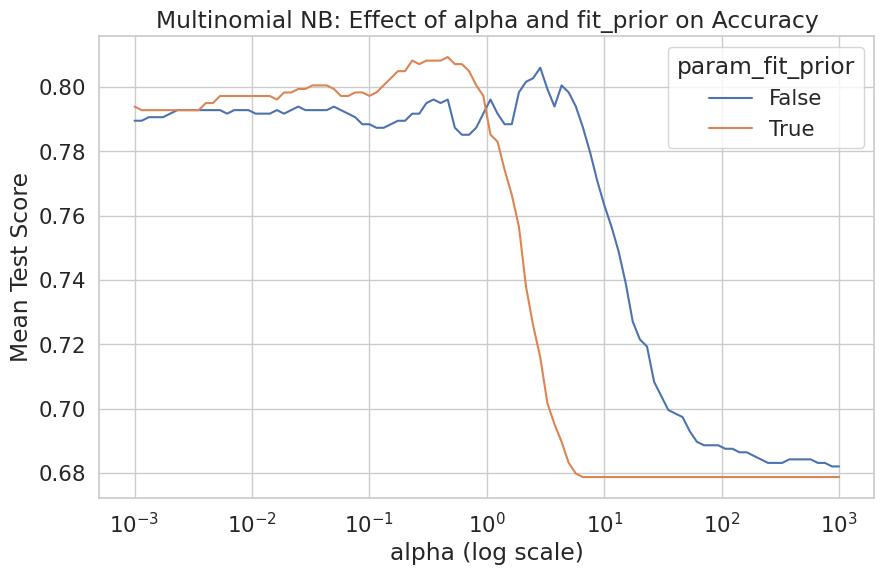

Performing Grid Search for Complement NB...
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best Parameters: {'alpha': np.float64(2.848035868435802), 'fit_prior': True}
Best Cross-Validation Score: 0.8060
Test Accuracy with Best Parameters: 0.7895


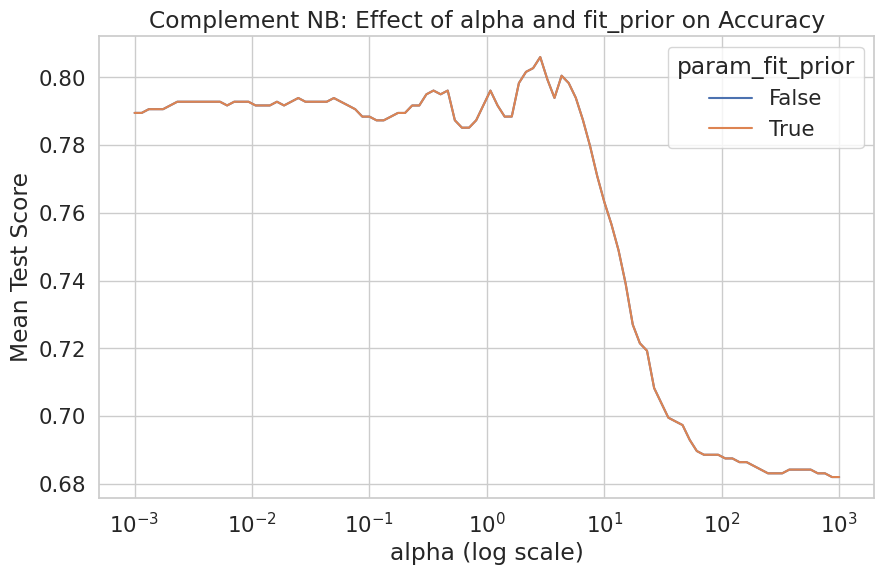

Performing Grid Search for Bernoulli NB...
Fitting 10 folds for each of 200 candidates, totalling 2000 fits
Best Parameters: {'alpha': np.float64(0.1747528400007685), 'fit_prior': True}
Best Cross-Validation Score: 0.8224
Test Accuracy with Best Parameters: 0.8070


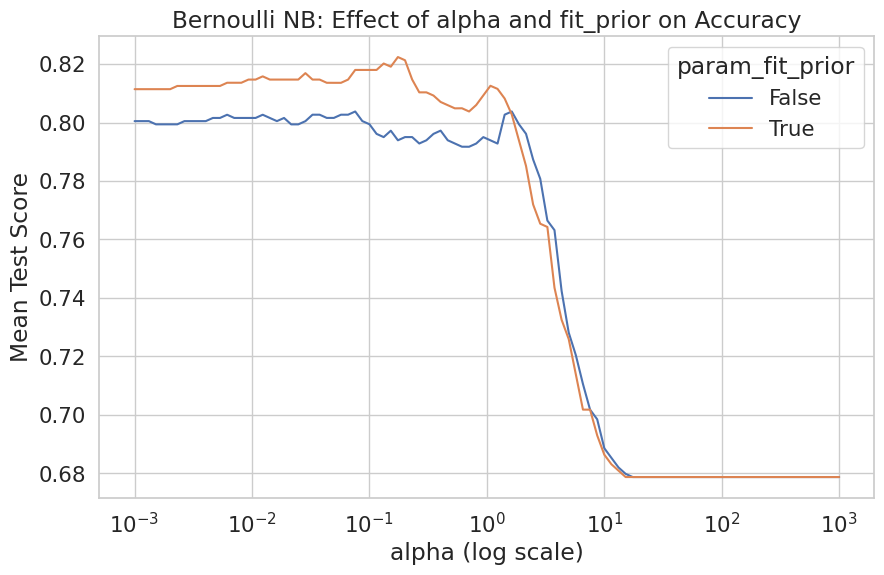

Performing Grid Search for KNN...
Fitting 10 folds for each of 16 candidates, totalling 160 fits
Best Parameters: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Best Cross-Validation Score: 0.7412
Test Accuracy with Best Parameters: 0.7237


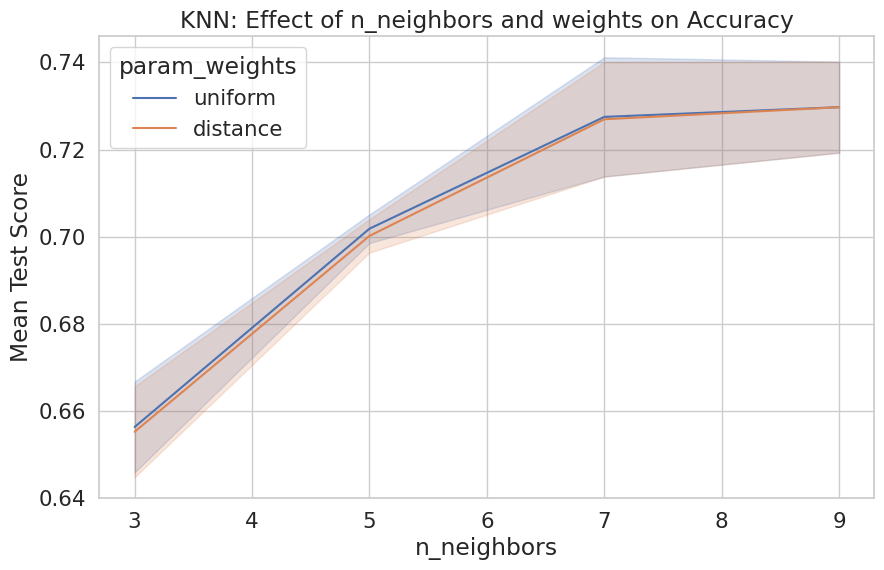

Performing Grid Search for SVM...
Fitting 10 folds for each of 400 candidates, totalling 4000 fits
Best Parameters: {'C': np.float64(1.4174741629268048), 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.8049
Test Accuracy with Best Parameters: 0.7719


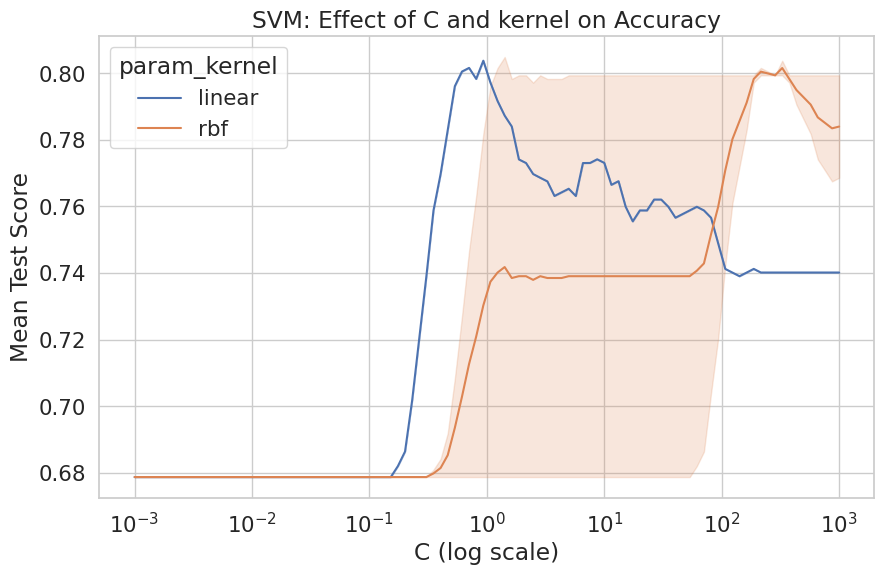

Performing Grid Search for Logistic Regression...
Fitting 10 folds for each of 400 candidates, totalling 4000 fits


/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_

Best Parameters: {'C': np.float64(4.328761281083062), 'penalty': 'l1', 'solver': 'saga'}
Best Cross-Validation Score: 0.8081
Test Accuracy with Best Parameters: 0.7939


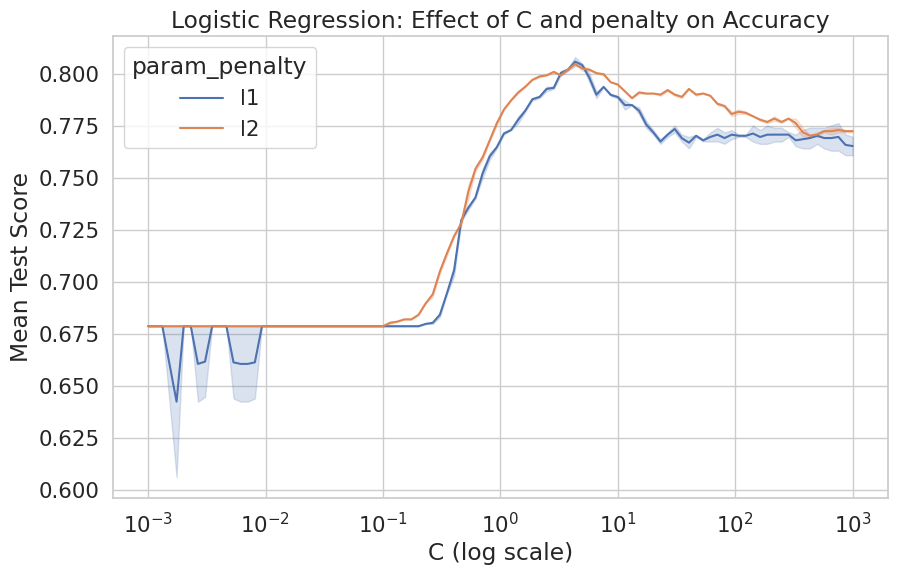

Performing Grid Search for Random Forest...
Fitting 10 folds for each of 108 candidates, totalling 1080 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Score: 0.7829
Test Accuracy with Best Parameters: 0.7763


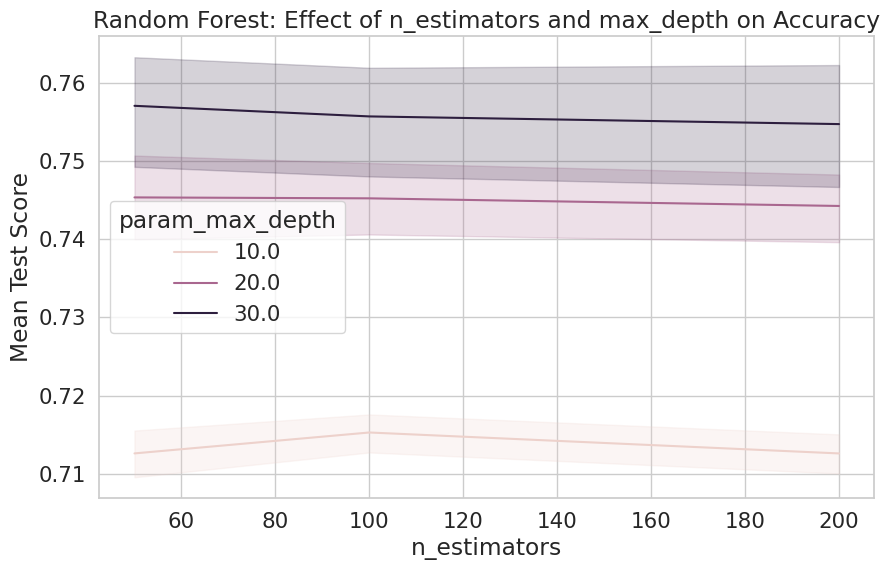

In [39]:
from sklearn.model_selection import GridSearchCV







for model_name, model in nb_models.items():
    print(f"Performing Grid Search for {model_name}...")
    # Define the parameter grid
    if model_name == 'Gaussian NB':
        param_grid = {
            'var_smoothing': np.
            logspace(0, -9, num=100)
        }
    elif model_name == 'Multinomial NB':
        param_grid = {
            'alpha': np.logspace(-3, 3, num=100),
            'fit_prior': [True, False]
        }
    elif model_name == 'Complement NB':
        param_grid = {
            'alpha': np.logspace(-3, 3, num=100),
            'fit_prior': [True, False]
        }
    elif model_name == 'Bernoulli NB':
        param_grid = {
            'alpha': np.logspace(-3, 3, num=100),
            'fit_prior': [True, False]
        }
    elif model_name == 'KNN':
        param_grid = {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    elif model_name == 'SVM':
        param_grid = {
            'C': np.logspace(-3, 3, num=100),
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    elif model_name == 'Logistic Regression':
        param_grid = {
            'C': np.logspace(-3, 3, num=100),
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    elif model_name == 'Random Forest':
        param_grid = {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    else:
        continue

    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1
    )
    

    # Fit the grid search to the data
    grid_search.fit(X_train_task1, y_train_task1)

    # Get the best parameters and best score
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")

    # Evaluate the best model
    best_model = grid_search.best_estimator_
    best_model_accuracy = best_model.score(X_test_task1, y_test_task1)
    print(f"Test Accuracy with Best Parameters: {best_model_accuracy:.4f}")

    # Visualize parameter impact
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Plot effect of parameters

    if model_name == 'Gaussian NB':
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x='param_var_smoothing', y='mean_test_score')
        plt.xscale('log')
        plt.title(f'Gaussian NB: Effect of var_smoothing on Accuracy')
        plt.xlabel('var_smoothing (log scale)')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()
    elif model_name == 'Multinomial NB':
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x='param_alpha', y='mean_test_score', hue='param_fit_prior')
        plt.xscale('log')
        plt.title(f'Multinomial NB: Effect of alpha and fit_prior on Accuracy')
        plt.xlabel('alpha (log scale)')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()
    elif model_name == 'Complement NB':
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x='param_alpha', y='mean_test_score', hue='param_fit_prior')
        plt.xscale('log')
        plt.title(f'Complement NB: Effect of alpha and fit_prior on Accuracy')
        plt.xlabel('alpha (log scale)')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()
    elif model_name == 'Bernoulli NB':
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x='param_alpha', y='mean_test_score', hue='param_fit_prior')
        plt.xscale('log')
        plt.title(f'Bernoulli NB: Effect of alpha and fit_prior on Accuracy')
        plt.xlabel('alpha (log scale)')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()
    elif model_name == 'KNN':
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x='param_n_neighbors', y='mean_test_score', hue='param_weights')
        plt.title(f'KNN: Effect of n_neighbors and weights on Accuracy')
        plt.xlabel('n_neighbors')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()
    elif model_name == 'SVM':
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x='param_C', y='mean_test_score', hue='param_kernel')
        plt.xscale('log')
        plt.title(f'SVM: Effect of C and kernel on Accuracy')
        plt.xlabel('C (log scale)')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()
    elif model_name == 'Logistic Regression':
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x='param_C', y='mean_test_score', hue='param_penalty')
        plt.xscale('log')
        plt.title(f'Logistic Regression: Effect of C and penalty on Accuracy')
        plt.xlabel('C (log scale)')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()
    elif model_name == 'Random Forest':
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=results, x='param_n_estimators', y='mean_test_score', hue='param_max_depth')
        plt.title(f'Random Forest: Effect of n_estimators and max_depth on Accuracy')
        plt.xlabel('n_estimators')
        plt.ylabel('Mean Test Score')
        plt.grid(True)
        plt.show()
    else:
        print(f"No visualization available for {model_name} model.")




# Training comparaison with best parameter

Performing 10-fold cross-validation for Gaussian NB with best parameters...
  Average: AUC=0.7703 ± 0.0396
  Average: Accuracy=0.7377 ± 0.0363
  Average: F1 Score=0.6381 ± 0.0403

Performing 10-fold cross-validation for Multinomial NB with best parameters...
  Average: AUC=0.8660 ± 0.0281
  Average: Accuracy=0.8000 ± 0.0277
  Average: F1 Score=0.6273 ± 0.0495

Performing 10-fold cross-validation for Complement NB with best parameters...
  Average: AUC=0.8549 ± 0.0274
  Average: Accuracy=0.7851 ± 0.0343
  Average: F1 Score=0.6695 ± 0.0449

Performing 10-fold cross-validation for Bernoulli NB with best parameters...
  Average: AUC=0.8681 ± 0.0237
  Average: Accuracy=0.8096 ± 0.0229
  Average: F1 Score=0.7092 ± 0.0316

Performing 10-fold cross-validation for KNN with best parameters...
  Average: AUC=0.7673 ± 0.0471
  Average: Accuracy=0.7263 ± 0.0260
  Average: F1 Score=0.5524 ± 0.0539

Performing 10-fold cross-validation for SVM with best parameters...
  Average: AUC=0.8655 ± 0.0212
  A

/tmp/ipykernel_368067/2330540877.py:127: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


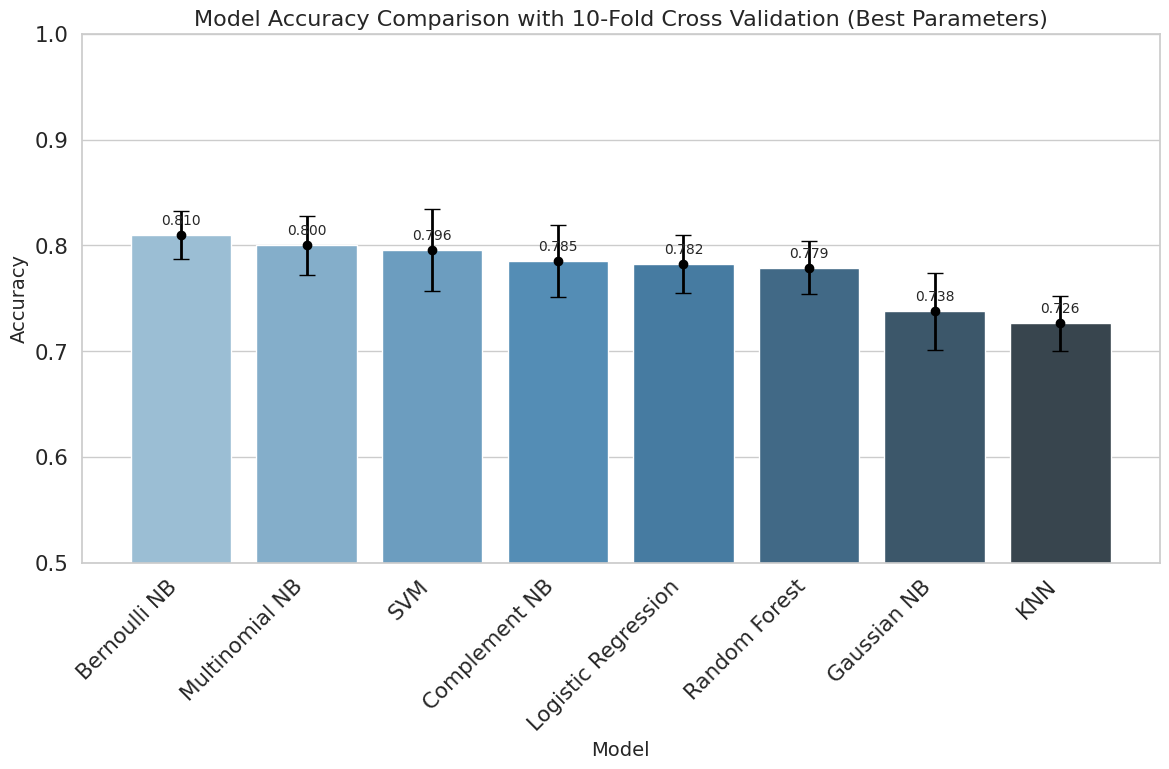

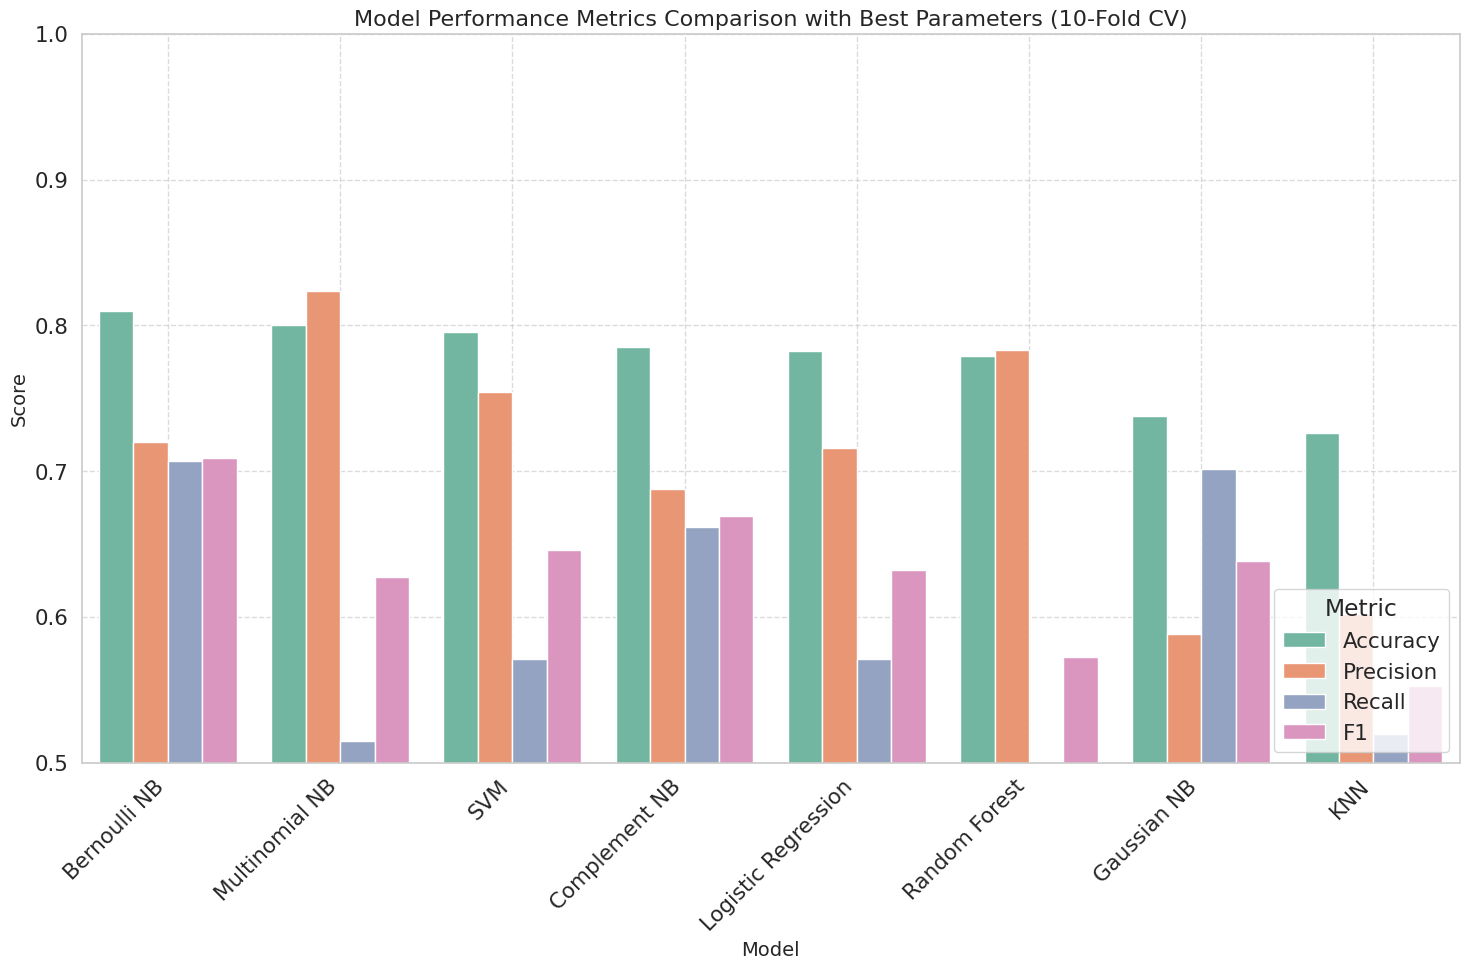

/tmp/ipykernel_368067/2330540877.py:224: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


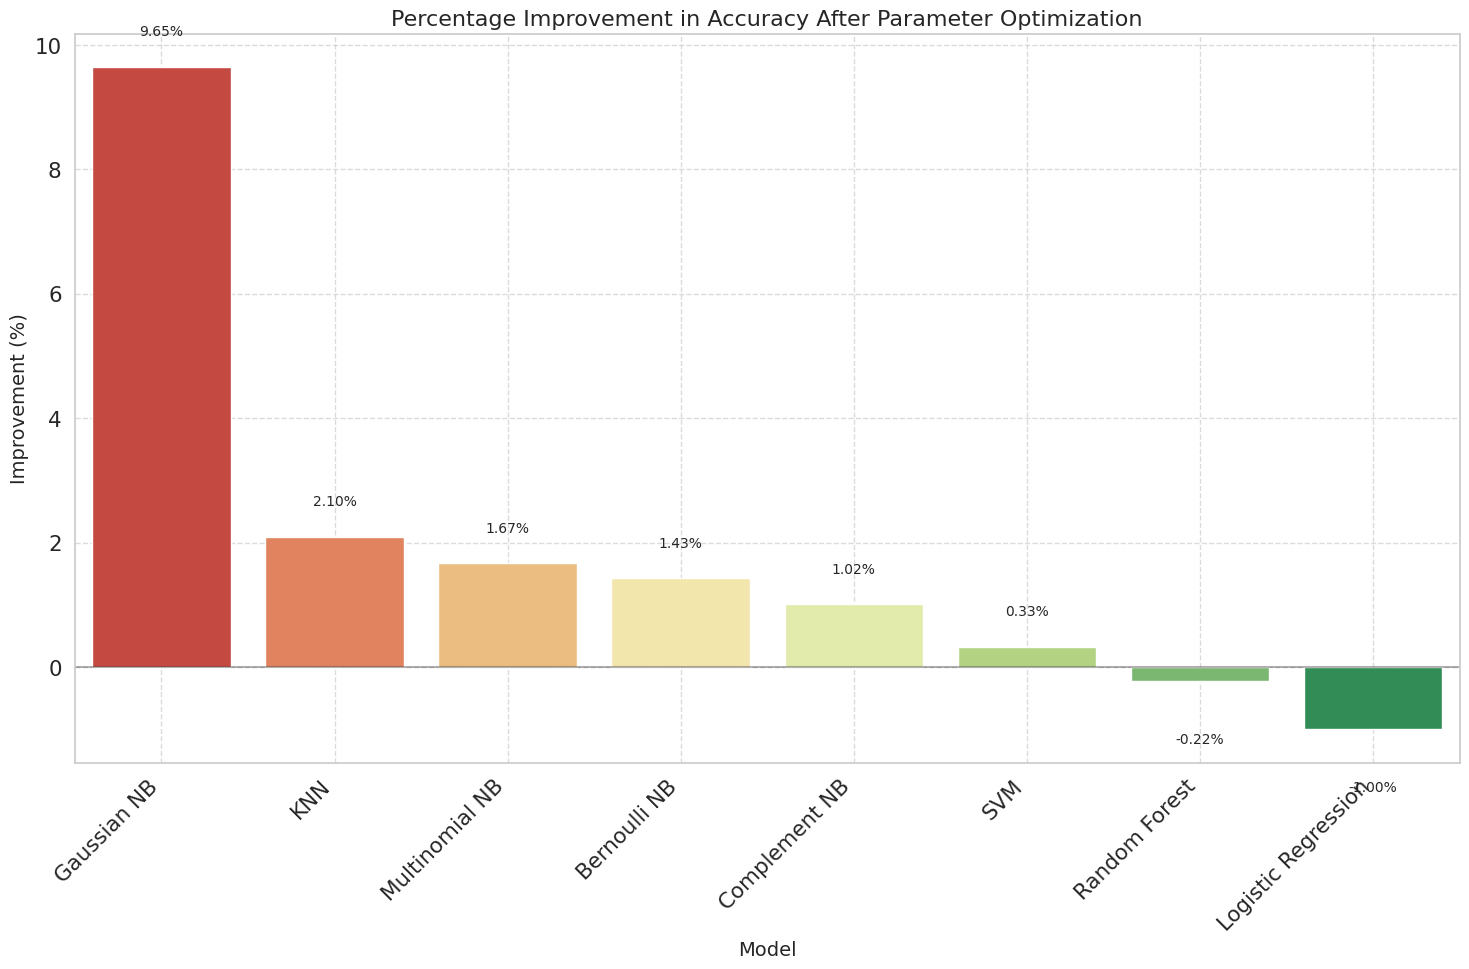

In [40]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# Create dictionary of models with their best parameters based on grid search results

# Define models with their best parameters based on grid search results
best_models = {
    'Gaussian NB': GaussianNB(var_smoothing=0.0152), #ample value - update based on grid search
    'Multinomial NB': MultinomialNB(alpha=0.4641, fit_prior=True),  # Example value
    'Complement NB': ComplementNB(alpha=2.8480, fit_prior=True),  # Example value
    'Bernoulli NB': BernoulliNB(alpha=0.17475, fit_prior=True),  # Example value
    'KNN': KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean'),
    'SVM': SVC(C=1.4174742, kernel='rbf', gamma='scale', probability=True),
    'Logistic Regression': LogisticRegression(C=np.float64(4.328761281083062), penalty='l1', solver='saga', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=1)
}

# Dictionary to store results
best_cv_results = {}

# Perform k-fold cross validation for each model
for model_name, model in best_models.items():
    print(f"Performing {k_folds}-fold cross-validation for {model_name} with best parameters...")
    
    # Initialize lists to store performance metrics for each fold
    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_auc = []
    
    # For each fold
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_dense, y_task1)):
        # Split data
        X_train_fold, X_test_fold = X_dense[train_idx], X_dense[test_idx]
        y_train_fold, y_test_fold = y_task1.iloc[train_idx], y_task1.iloc[test_idx]
        
        # Train model
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate metrics
        acc = accuracy_score(y_test_fold, y_pred_fold)
        prec = precision_score(y_test_fold, y_pred_fold, zero_division=0)
        rec = recall_score(y_test_fold, y_pred_fold, zero_division=0)
        f1 = f1_score(y_test_fold, y_pred_fold, zero_division=0)
        
        # For AUC, we need probability estimates
        try:
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test_fold)[:, 1]
                auc_score = roc_auc_score(y_test_fold, y_prob)
                fold_auc.append(auc_score)
        except:
            pass
        
        fold_accuracy.append(acc)
        fold_precision.append(prec)
        fold_recall.append(rec)
        fold_f1.append(f1)
    
    # Store average metrics and standard deviations
    best_cv_results[model_name] = {
        'accuracy': {
            'mean': np.mean(fold_accuracy),
            'std': np.std(fold_accuracy)
        },
        'precision': {
            'mean': np.mean(fold_precision),
            'std': np.std(fold_precision)
        },
        'recall': {
            'mean': np.mean(fold_recall),
            'std': np.std(fold_recall)
        },
        'f1': {
            'mean': np.mean(fold_f1),
            'std': np.std(fold_f1)
        }
    }
    
    if fold_auc:
        best_cv_results[model_name]['auc'] = {
            'mean': np.mean(fold_auc),
            'std': np.std(fold_auc)
        }
        print(f"  Average: AUC={best_cv_results[model_name]['auc']['mean']:.4f} ± {best_cv_results[model_name]['auc']['std']:.4f}")
    
    print(f"  Average: Accuracy={best_cv_results[model_name]['accuracy']['mean']:.4f} ± {best_cv_results[model_name]['accuracy']['std']:.4f}")
    print(f"  Average: F1 Score={best_cv_results[model_name]['f1']['mean']:.4f} ± {best_cv_results[model_name]['f1']['std']:.4f}")
    print()

# Create DataFrame for visualization
best_results_df = pd.DataFrame({
    'Model': [],
    'Metric': [],
    'Mean': [],
    'Std': []
})

for model_name in best_cv_results:
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        best_results_df = pd.concat([best_results_df, pd.DataFrame({
            'Model': [model_name],
            'Metric': [metric.capitalize()],
            'Mean': [best_cv_results[model_name][metric]['mean']],
            'Std': [best_cv_results[model_name][metric]['std']]
        })], ignore_index=True)
    if 'auc' in best_cv_results[model_name]:
        best_results_df = pd.concat([best_results_df, pd.DataFrame({
            'Model': [model_name],
            'Metric': ['AUC'],
            'Mean': [best_cv_results[model_name]['auc']['mean']],
            'Std': [best_cv_results[model_name]['auc']['std']]
        })], ignore_index=True)

# Sort models by accuracy
best_model_order = best_results_df[best_results_df['Metric'] == 'Accuracy'].sort_values('Mean', ascending=False)['Model'].tolist()

# Create plots
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create bar plot for accuracy
ax = sns.barplot(
    data=best_results_df[best_results_df['Metric'] == 'Accuracy'],
    x='Model',
    y='Mean',
    order=best_model_order,
    palette='Blues_d'
)

# Add error bars
for i, model in enumerate(best_model_order):
    row = best_results_df[(best_results_df['Model'] == model) & (best_results_df['Metric'] == 'Accuracy')].iloc[0]
    ax.errorbar(
        i, row['Mean'], yerr=row['Std'],
        fmt='o', color='black', elinewidth=2, capsize=6
    )

# Add value labels on top of bars
for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.3f}",
        ha='center',
        fontsize=10
    )

plt.title(f'Model Accuracy Comparison with {k_folds}-Fold Cross Validation (Best Parameters)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

# Create a grouped bar chart for all metrics
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Create grouped bar plot
ax = sns.barplot(
    data=best_results_df[best_results_df['Metric'] != 'AUC'],
    x='Model',
    y='Mean',
    hue='Metric',
    order=best_model_order,
    palette='Set2'
)

plt.title(f'Model Performance Metrics Comparison with Best Parameters ({k_folds}-Fold CV)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='lower right')
plt.ylim([0.5, 1.0])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Create a comparison table between original results and optimized results
comparison_df = pd.DataFrame({
    'Model': [],
    'Metric': [],
    'Original Mean': [],
    'Original Std': [],
    'Optimized Mean': [],
    'Optimized Std': [],
    'Improvement': []
})

for model_name in best_cv_results:
    if model_name in cv_results:
        for metric in ['accuracy', 'precision', 'recall', 'f1']:
            orig_mean = cv_results[model_name][metric]['mean']
            orig_std = cv_results[model_name][metric]['std']
            opt_mean = best_cv_results[model_name][metric]['mean']
            opt_std = best_cv_results[model_name][metric]['std']
            improvement = ((opt_mean - orig_mean) / orig_mean) * 100
            
            comparison_df = pd.concat([comparison_df, pd.DataFrame({
                'Model': [model_name],
                'Metric': [metric.capitalize()],
                'Original Mean': [orig_mean],
                'Original Std': [orig_std],
                'Optimized Mean': [opt_mean],
                'Optimized Std': [opt_std],
                'Improvement': [improvement]
            })], ignore_index=True)

# Plot the improvement in accuracy
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Filter for accuracy only
acc_comparison = comparison_df[comparison_df['Metric'] == 'Accuracy']
acc_comparison = acc_comparison.sort_values('Improvement', ascending=False)

# Create bar chart of improvements
ax = sns.barplot(
    data=acc_comparison,
    x='Model',
    y='Improvement',
    palette='RdYlGn',
    dodge=False
)

plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for i, bar in enumerate(ax.patches):
    if bar.get_height() >= 0:
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() + 0.5,
            f"{bar.get_height():.2f}%",
            ha='center',
            fontsize=10
        )
    else:
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height() - 1.0,
            f"{bar.get_height():.2f}%",
            ha='center',
            fontsize=10
        )

plt.title('Percentage Improvement in Accuracy After Parameter Optimization', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Improvement (%)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Preprocessing

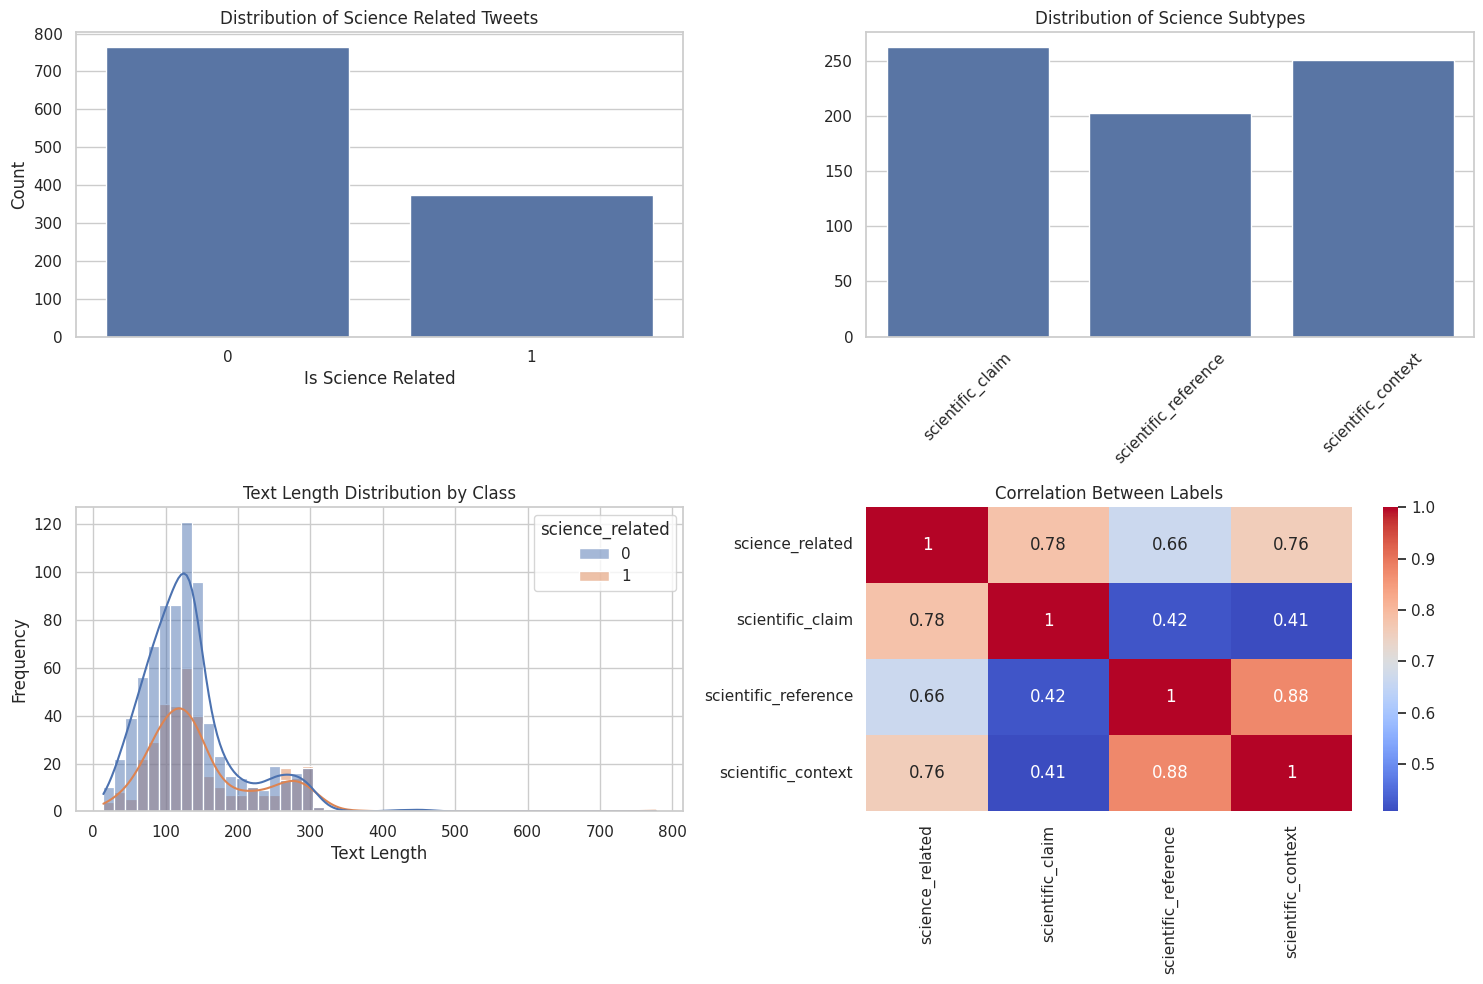

In [41]:

import numpy as np

# Set style
sns.set(style="whitegrid")
plt.figure(figsize=(15, 10))

# Plot distribution of science_related tweets
plt.subplot(2, 2, 1)
sns.countplot(x='science_related', data=df)
plt.title('Distribution of Science Related Tweets')
plt.xlabel('Is Science Related')
plt.ylabel('Count')

# Plot distribution of science subtypes for science-related tweets
sci_df = df[df['science_related'] == 1]
plt.subplot(2, 2, 2)
subtypes = ['scientific_claim', 'scientific_reference', 'scientific_context']
sns.barplot(x=subtypes, y=[sci_df[col].sum() for col in subtypes])
plt.title('Distribution of Science Subtypes')
plt.xticks(rotation=45)
plt.tight_layout()

# Plot text length distribution
plt.subplot(2, 2, 3)
df['text_length'] = df['text'].apply(len)
sns.histplot(data=df, x='text_length', hue='science_related', bins=50, kde=True)
plt.title('Text Length Distribution by Class')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

# Plot correlation between features
plt.subplot(2, 2, 4)
corr_cols = ['science_related', 'scientific_claim', 'scientific_reference', 'scientific_context']
sns.heatmap(df[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Labels')

plt.tight_layout()
plt.show()

In [42]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import emoji

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Demojize text
    text = emoji.demojize(text)
    
    # Remove URLs
    text = re.sub(r'(http\S+|www\S+)', '', text)


   
    # Remove mentions and hashtags execept for the word uurekamag
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#eurekamag', 'eurekamag', text)
    text = re.sub(r'#\w+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = nltk.word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]


    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoin
    return ' '.join(tokens)

# Apply preprocessing to the dataset
df['processed_text'] = df['text'].apply(preprocess_text)

# Compare before and after
comparison_df = pd.DataFrame({
    'Original': df['text'].head(5),
    'Preprocessed': df['processed_text'].head(5)
})
comparison_df

[nltk_data] Downloading package stopwords to /home/hurel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/hurel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/hurel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/hurel/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


,Original,Preprocessed
0,Knees are a bit sore. i guess that's a sign th...,knee bit sore guess thats sign recent treadmil...
1,McDonald's breakfast stop then the gym 🏀💪,mcdonalds breakfast stop gym basketballflexedb...
2,Can any Gynecologist with Cancer Experience ex...,gynecologist cancer experience explain danger ...
3,Couch-lock highs lead to sleeping in the couch...,couchlock high lead sleeping couch got ta stop...
4,Does daily routine help prevent problems with ...,daily routine help prevent problem bipolar dis...


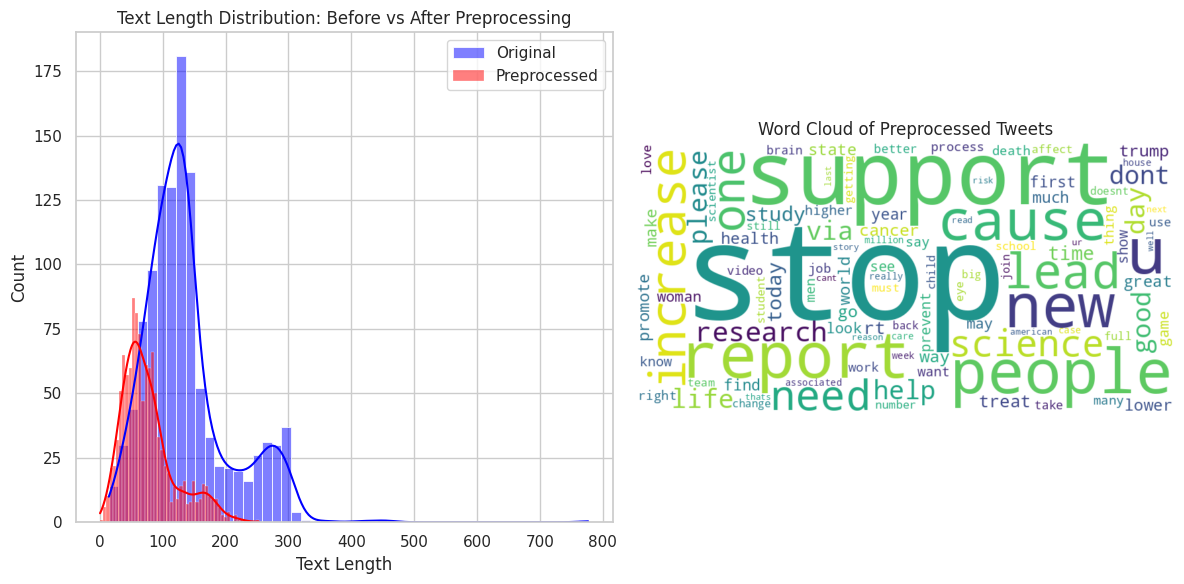

In [43]:
# Visualize the impact of preprocessing
plt.figure(figsize=(12, 6))

# Text length before and after preprocessing
df['original_length'] = df['text'].apply(len)
df['processed_length'] = df['processed_text'].apply(len)

plt.subplot(1, 2, 1)
sns.histplot(data=df, x='original_length', color='blue', bins=50, kde=True, label='Original')
sns.histplot(data=df, x='processed_length', color='red', bins=50, kde=True, label='Preprocessed')
plt.title('Text Length Distribution: Before vs After Preprocessing')
plt.xlabel('Text Length')
plt.legend()

# Word cloud for processed text
from wordcloud import WordCloud

plt.subplot(1, 2, 2)
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(' '.join(df['processed_text']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Preprocessed Tweets')

plt.tight_layout()
plt.show()

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_all = vectorizer.fit_transform(df['text'])

Count Vectorizer Features: (1140, 5000)
TF-IDF Vectorizer Features: (1140, 465)
TF-IDF on Preprocessed Text Features: (1140, 5000)


/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and binary values for target
  warnings.warn(msg, UserWarning)
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/cluster/_supervised.py:59: UserWarning: Clustering metrics expects discrete values b


Features after Chi-squared selection: (1140, 100)
Features after Mutual Information selection: (1140, 100)


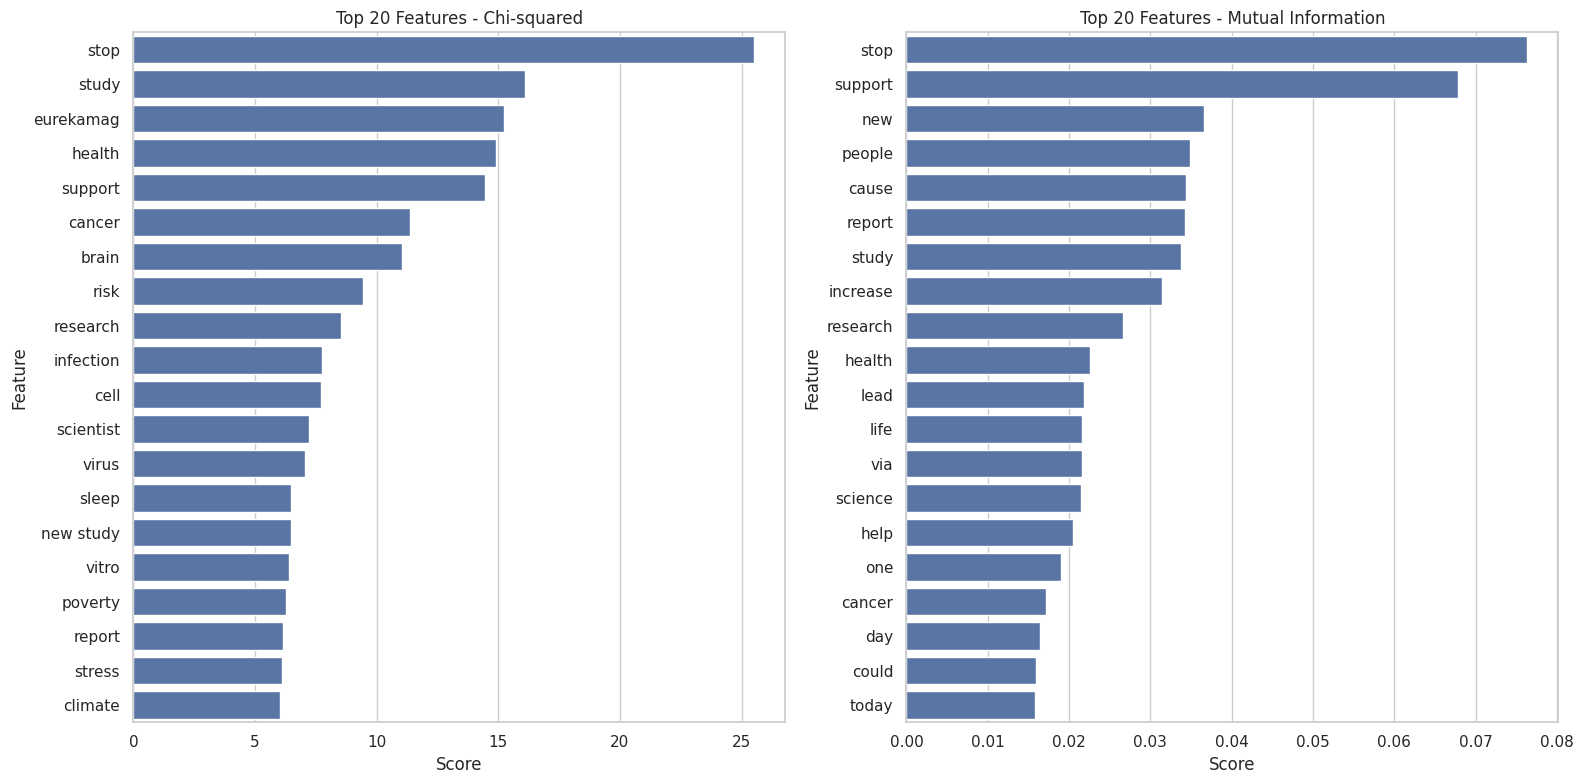

In [45]:
# Compare different feature extraction methods
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# Create label for Task 1
y_task1 = df['science_related']

# 1. Count Vectorizer
count_vec = CountVectorizer(max_features=5000)
X_count = count_vec.fit_transform(df['processed_text'])

# 2. TF-IDF with more parameters
tfidf_vec = TfidfVectorizer(max_features=5000, 
                           min_df=5, 
                           max_df=0.8, 
                           ngram_range=(1, 2))
X_tfidf = tfidf_vec.fit_transform(df['processed_text'])

# 3. TF-IDF with preprocessing already done
tfidf_processed = TfidfVectorizer(max_features=5000)
X_tfidf_processed = tfidf_processed.fit_transform(df['processed_text'])

# Compare feature extraction methods
print(f"Count Vectorizer Features: {X_count.shape}")
print(f"TF-IDF Vectorizer Features: {X_tfidf.shape}")
print(f"TF-IDF on Preprocessed Text Features: {X_tfidf_processed.shape}")

# Feature selection using Chi-squared
selector_chi2 = SelectKBest(chi2, k=100)
X_chi2 = selector_chi2.fit_transform(X_tfidf, y_task1)

# Feature selection using Mutual Information
selector_mi = SelectKBest(mutual_info_classif, k=100)
X_mi = selector_mi.fit_transform(X_tfidf, y_task1)

print(f"\nFeatures after Chi-squared selection: {X_chi2.shape}")
print(f"Features after Mutual Information selection: {X_mi.shape}")

# Get and visualize the most important features
chi2_selected_indices = selector_chi2.get_support(indices=True)
mi_selected_indices = selector_mi.get_support(indices=True)

chi2_feature_names = np.array(tfidf_vec.get_feature_names_out())[chi2_selected_indices]
mi_feature_names = np.array(tfidf_vec.get_feature_names_out())[mi_selected_indices]

# Plot top 20 features by importance
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
chi2_scores = selector_chi2.scores_[chi2_selected_indices]
chi2_features_df = pd.DataFrame({'Feature': chi2_feature_names, 'Score': chi2_scores})
chi2_features_df = chi2_features_df.sort_values('Score', ascending=False).head(20)
sns.barplot(x='Score', y='Feature', data=chi2_features_df)
plt.title('Top 20 Features - Chi-squared')

plt.subplot(1, 2, 2)
mi_scores = selector_mi.scores_[mi_selected_indices]
mi_features_df = pd.DataFrame({'Feature': mi_feature_names, 'Score': mi_scores})
mi_features_df = mi_features_df.sort_values('Score', ascending=False).head(20)
sns.barplot(x='Score', y='Feature', data=mi_features_df)
plt.title('Top 20 Features - Mutual Information')

plt.tight_layout()
plt.show()

# We'll use the TF-IDF on preprocessed text for subsequent modeling
X_selected = X_tfidf

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Function to evaluate model performance
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, y_pred))
    
    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'report': report,
        'confusion_matrix': cm,
        'y_pred': y_pred
    }

# Get a dense version of our features for Gaussian NB
X_dense = X_selected.toarray()

# Split data for Task 1
X_train_task1, X_test_task1, y_train_task1, y_test_task1 = train_test_split(
    X_dense, df['task1_label'], test_size=0.2, random_state=42
)

# Define models with their best parameters based on grid search results
nb_models = {
    'Gaussian NB': GaussianNB(var_smoothing=0.0152), #ample value - update based on grid search
    'Multinomial NB': MultinomialNB(alpha=0.4641, fit_prior=True),  # Example value
    'Complement NB': ComplementNB(alpha=2.8480, fit_prior=True),  # Example value
    'Bernoulli NB': BernoulliNB(alpha=0.17475, fit_prior=True),  # Example value
    'KNN': KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean'),
    'SVM': SVC(C=1.4174742, kernel='rbf', gamma='scale', probability=True),
    'Logistic Regression': LogisticRegression(C=np.float64(4.328761281083062), penalty='l1', solver='saga', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=1)
}

task1_results = {}
print("Task 1: Science Related Classification\n" + "="*40)
for name, model in nb_models.items():
    task1_results[name] = evaluate_model(
        model, X_train_task1, X_test_task1, y_train_task1, y_test_task1, name
    )
    print("\n")


Task 1: Science Related Classification
Model: Gaussian NB
Accuracy: 0.6798
              precision    recall  f1-score   support

           0       0.80      0.66      0.73       146
           1       0.54      0.71      0.61        82

    accuracy                           0.68       228
   macro avg       0.67      0.69      0.67       228
weighted avg       0.71      0.68      0.69       228



Model: Multinomial NB
Accuracy: 0.7412
              precision    recall  f1-score   support

           0       0.75      0.89      0.82       146
           1       0.71      0.48      0.57        82

    accuracy                           0.74       228
   macro avg       0.73      0.68      0.69       228
weighted avg       0.74      0.74      0.73       228



Model: Complement NB
Accuracy: 0.7500
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       146
           1       0.64      0.70      0.67        82

    accuracy              

Performing 10-fold cross-validation for Gaussian NB with best parameters on preprocessed text...
  Average: AUC=0.7498 ± 0.0386
  Average: Accuracy=0.7211 ± 0.0332
  Average: F1 Score=0.6283 ± 0.0560

Performing 10-fold cross-validation for Multinomial NB with best parameters on preprocessed text...
  Average: AUC=0.8442 ± 0.0334
  Average: Accuracy=0.7895 ± 0.0370
  Average: F1 Score=0.6251 ± 0.0685

Performing 10-fold cross-validation for Complement NB with best parameters on preprocessed text...
  Average: AUC=0.8550 ± 0.0328
  Average: Accuracy=0.7675 ± 0.0310
  Average: F1 Score=0.6750 ± 0.0425

Performing 10-fold cross-validation for Bernoulli NB with best parameters on preprocessed text...
  Average: AUC=0.8421 ± 0.0246
  Average: Accuracy=0.7851 ± 0.0270
  Average: F1 Score=0.6510 ± 0.0474

Performing 10-fold cross-validation for KNN with best parameters on preprocessed text...
  Average: AUC=0.6058 ± 0.0533
  Average: Accuracy=0.5886 ± 0.0745
  Average: F1 Score=0.4461 ± 0.115

/tmp/ipykernel_368067/2418365623.py:144: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


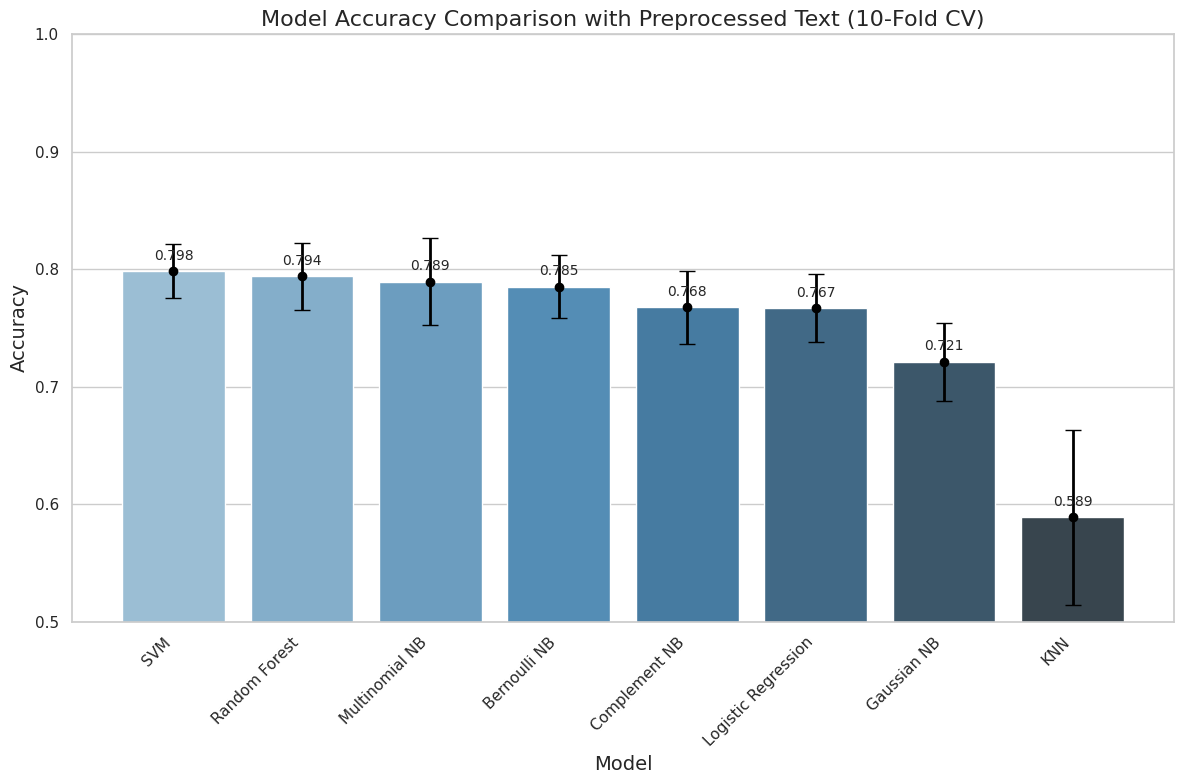

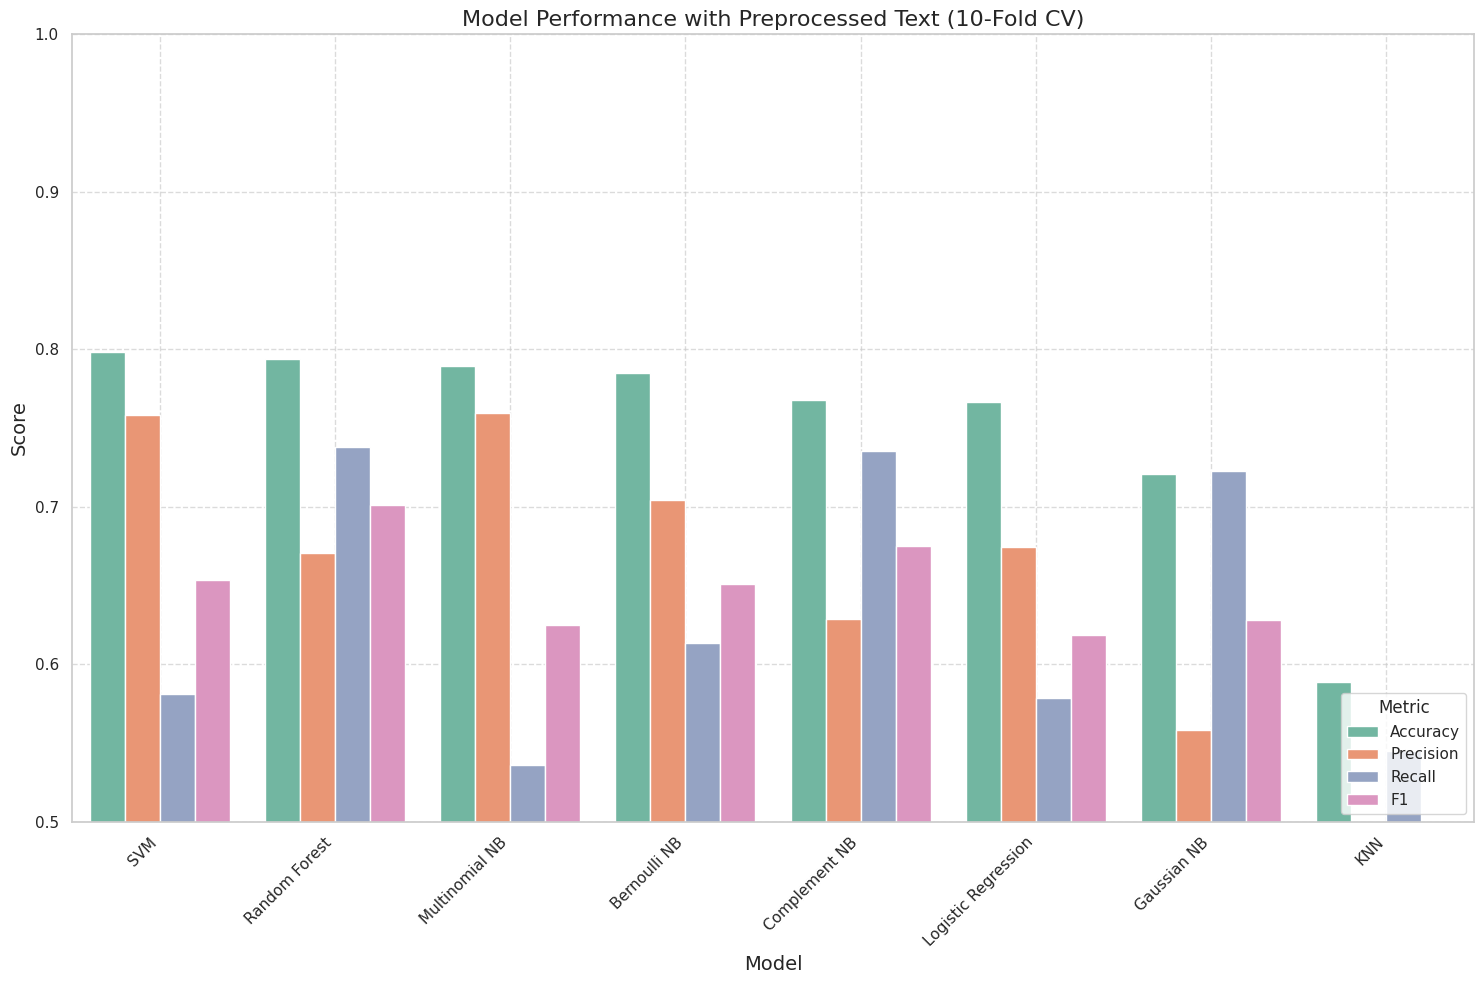

In [47]:
# Using preprocessed text for feature extraction
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

# Create TF-IDF features from preprocessed text
tfidf_vec = TfidfVectorizer(max_features=5000, 
                           min_df=5, 
                           max_df=0.8, 
                           ngram_range=(1, 2))
X_tfidf_processed = tfidf_vec.fit_transform(df['processed_text'])

# Feature selection using Chi-squared
selector_chi2 = SelectKBest(chi2, k=100)
X_chi2_processed = selector_chi2.fit_transform(X_tfidf_processed, y_task1)

# Get a dense version of our features for models that require it
X_processed_dense = X_tfidf_processed.toarray()

# Initialize k-fold cross validation
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Define models with their best parameters based on grid search results
best_models = {
    'Gaussian NB': GaussianNB(var_smoothing=0.0152),
    'Multinomial NB': MultinomialNB(alpha=0.4641, fit_prior=True),
    'Complement NB': ComplementNB(alpha=2.8480, fit_prior=True),
    'Bernoulli NB': BernoulliNB(alpha=0.17475, fit_prior=True),
    'KNN': KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean'),
    'SVM': SVC(C=1.4174742, kernel='rbf', gamma='scale', probability=True),
    'Logistic Regression': LogisticRegression(C=np.float64(4.328761281083062), penalty='l1', solver='saga', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=1)
}

# Dictionary to store results
best_cv_results = {}

# Perform k-fold cross validation for each model
for model_name, model in best_models.items():
    print(f"Performing {k_folds}-fold cross-validation for {model_name} with best parameters on preprocessed text...")
    
    # Initialize lists to store performance metrics for each fold
    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_auc = []
    
    # For each fold
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_processed_dense, y_task1)):
        # Split data
        X_train_fold, X_test_fold = X_processed_dense[train_idx], X_processed_dense[test_idx]
        y_train_fold, y_test_fold = y_task1.iloc[train_idx], y_task1.iloc[test_idx]
        
        # Train model
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate metrics
        acc = accuracy_score(y_test_fold, y_pred_fold)
        prec = precision_score(y_test_fold, y_pred_fold, zero_division=0)
        rec = recall_score(y_test_fold, y_pred_fold, zero_division=0)
        f1 = f1_score(y_test_fold, y_pred_fold, zero_division=0)
        
        # For AUC, we need probability estimates
        try:
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test_fold)[:, 1]
                auc_score = roc_auc_score(y_test_fold, y_prob)
                fold_auc.append(auc_score)
        except:
            pass
        
        fold_accuracy.append(acc)
        fold_precision.append(prec)
        fold_recall.append(rec)
        fold_f1.append(f1)
    
    # Store average metrics and standard deviations
    best_cv_results[model_name] = {
        'accuracy': {
            'mean': np.mean(fold_accuracy),
            'std': np.std(fold_accuracy)
        },
        'precision': {
            'mean': np.mean(fold_precision),
            'std': np.std(fold_precision)
        },
        'recall': {
            'mean': np.mean(fold_recall),
            'std': np.std(fold_recall)
        },
        'f1': {
            'mean': np.mean(fold_f1),
            'std': np.std(fold_f1)
        }
    }
    
    if fold_auc:
        best_cv_results[model_name]['auc'] = {
            'mean': np.mean(fold_auc),
            'std': np.std(fold_auc)
        }
        print(f"  Average: AUC={best_cv_results[model_name]['auc']['mean']:.4f} ± {best_cv_results[model_name]['auc']['std']:.4f}")
    
    print(f"  Average: Accuracy={best_cv_results[model_name]['accuracy']['mean']:.4f} ± {best_cv_results[model_name]['accuracy']['std']:.4f}")
    print(f"  Average: F1 Score={best_cv_results[model_name]['f1']['mean']:.4f} ± {best_cv_results[model_name]['f1']['std']:.4f}")
    print()

# Create DataFrame for visualization
best_results_df = pd.DataFrame({
    'Model': [],
    'Metric': [],
    'Mean': [],
    'Std': []
})

for model_name in best_cv_results:
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        best_results_df = pd.concat([best_results_df, pd.DataFrame({
            'Model': [model_name],
            'Metric': [metric.capitalize()],
            'Mean': [best_cv_results[model_name][metric]['mean']],
            'Std': [best_cv_results[model_name][metric]['std']]
        })], ignore_index=True)
    if 'auc' in best_cv_results[model_name]:
        best_results_df = pd.concat([best_results_df, pd.DataFrame({
            'Model': [model_name],
            'Metric': ['AUC'],
            'Mean': [best_cv_results[model_name]['auc']['mean']],
            'Std': [best_cv_results[model_name]['auc']['std']]
        })], ignore_index=True)

# Sort models by accuracy
best_model_order = best_results_df[best_results_df['Metric'] == 'Accuracy'].sort_values('Mean', ascending=False)['Model'].tolist()

# Create plots
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create bar plot for accuracy
ax = sns.barplot(
    data=best_results_df[best_results_df['Metric'] == 'Accuracy'],
    x='Model',
    y='Mean',
    order=best_model_order,
    palette='Blues_d'
)

# Add error bars
for i, model in enumerate(best_model_order):
    row = best_results_df[(best_results_df['Model'] == model) & (best_results_df['Metric'] == 'Accuracy')].iloc[0]
    ax.errorbar(
        i, row['Mean'], yerr=row['Std'],
        fmt='o', color='black', elinewidth=2, capsize=6
    )

# Add value labels on top of bars
for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.3f}",
        ha='center',
        fontsize=10
    )

plt.title(f'Model Accuracy Comparison with Preprocessed Text ({k_folds}-Fold CV)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

# Create a grouped bar chart for all metrics
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Create grouped bar plot
ax = sns.barplot(
    data=best_results_df[best_results_df['Metric'] != 'AUC'],
    x='Model',
    y='Mean',
    hue='Metric',
    order=best_model_order,
    palette='Set2'
)

plt.title(f'Model Performance with Preprocessed Text ({k_folds}-Fold CV)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='lower right')
plt.ylim([0.5, 1.0])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

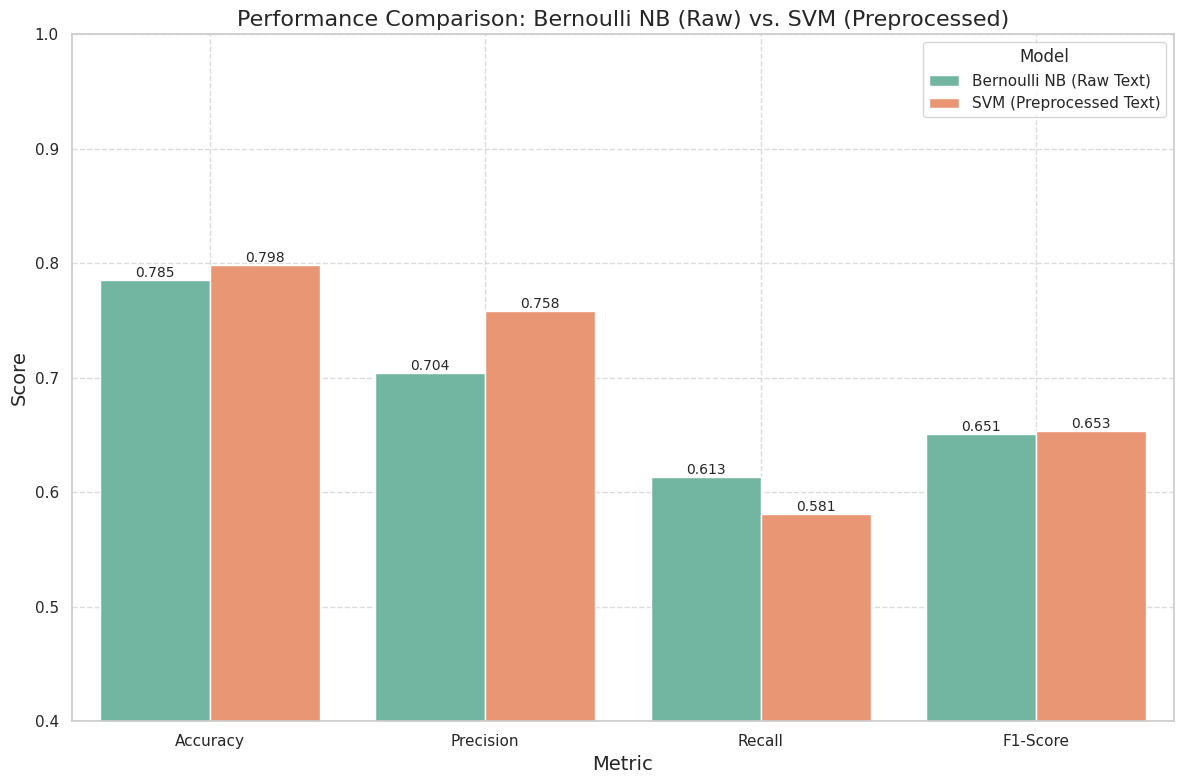


Performance Summary:
                         Accuracy  Precision    Recall  F1-Score
Model                                                           
Bernoulli NB (Raw Text)  0.785088   0.704412  0.613158  0.651009
SVM (Preprocessed Text)  0.798246   0.758331  0.581081  0.653448

Difference in Accuracy: 0.013
Difference in F1-Score: 0.002

Conclusion: SVM with preprocessed text performs better in terms of accuracy.
This suggests that text preprocessing is beneficial for this classification task.


In [48]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Compare performance of SVM with preprocessed data and Bernoulli NB without preprocessed data
import matplotlib.pyplot as plt

# Create a DataFrame for comparison
comparison_data = [
    {
        'Model': 'Bernoulli NB (Raw Text)',
        'Accuracy': best_cv_results['Bernoulli NB']['accuracy']['mean'],
        'Precision': best_cv_results['Bernoulli NB']['precision']['mean'],
        'Recall': best_cv_results['Bernoulli NB']['recall']['mean'],
        'F1-Score': best_cv_results['Bernoulli NB']['f1']['mean']
    },
    {
        'Model': 'SVM (Preprocessed Text)',
        'Accuracy': best_cv_results['SVM']['accuracy']['mean'],
        'Precision': best_cv_results['SVM']['precision']['mean'],
        'Recall': best_cv_results['SVM']['recall']['mean'],
        'F1-Score': best_cv_results['SVM']['f1']['mean']
    }
]

# Create DataFrame
compare_df = pd.DataFrame(comparison_data)

# Reshape data for visualization
compare_melted = pd.melt(compare_df, id_vars='Model', 
                         value_vars=['Accuracy', 'Precision', 'Recall', 'F1-Score'],
                         var_name='Metric', value_name='Score')

# Plot comparison
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create grouped bar chart
ax = sns.barplot(data=compare_melted, x='Metric', y='Score', hue='Model', palette='Set2')

plt.title('Performance Comparison: Bernoulli NB (Raw) vs. SVM (Preprocessed)', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.ylim([0.4, 1.0])
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Model')

# Add value labels on bars
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'bottom',
                fontsize=10)

plt.tight_layout()
plt.show()

# Statistical significance test (if applicable)
print("\nPerformance Summary:")
print(compare_df.set_index('Model'))

# Analyze differences
diff_accuracy = abs(comparison_data[0]['Accuracy'] - comparison_data[1]['Accuracy'])
diff_f1 = abs(comparison_data[0]['F1-Score'] - comparison_data[1]['F1-Score'])
print(f"\nDifference in Accuracy: {diff_accuracy:.3f}")
print(f"Difference in F1-Score: {diff_f1:.3f}")

# Print conclusions
if comparison_data[0]['Accuracy'] > comparison_data[1]['Accuracy']:
    winner = "Bernoulli NB with raw text"
else:
    winner = "SVM with preprocessed text"

print(f"\nConclusion: {winner} performs better in terms of accuracy.")
print("This suggests that " + 
      ("text preprocessing is beneficial for this classification task." 
       if winner == "SVM with preprocessed text" 
       else "raw text features might contain important signals that are lost during preprocessing."))

In [49]:
best_model = best_models['SVM']



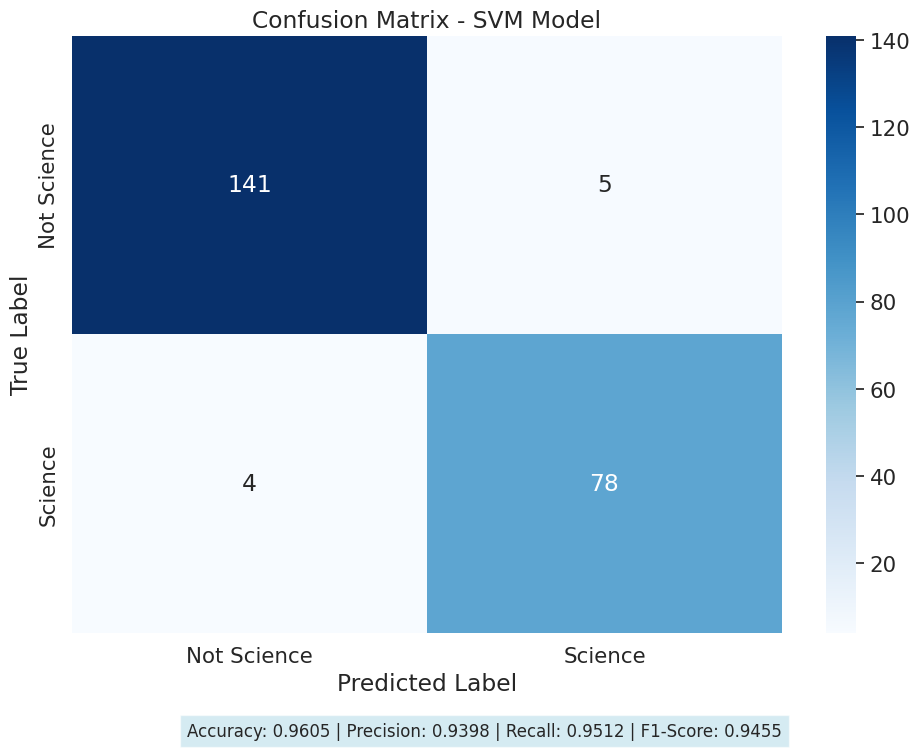

In [50]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt

# Get predictions from the best model on the test set
y_pred = best_model.predict(X_test_task1)

# Calculate the confusion matrix
cm = confusion_matrix(y_test_task1, y_pred)

# Create a prettier visualization of the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.4)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=['Not Science', 'Science'],
                 yticklabels=['Not Science', 'Science'])

# Add labels, title and ticks
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix - SVM Model')

# Calculate metrics
report = classification_report(y_test_task1, y_pred, output_dict=True)
accuracy = (cm[0, 0] + cm[1, 1]) / np.sum(cm)
precision = report['1']['precision']
recall = report['1']['recall']
f1 = report['1']['f1-score']

# Display metrics on the plot
plt.figtext(0.5, 0.01, f'Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}', 
            ha='center', fontsize=12, bbox={'facecolor': 'lightblue', 'alpha': 0.5, 'pad': 5})

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [51]:

%pip install imbalanced-learn

# Import required modules
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

Note: you may need to restart the kernel to use updated packages.


In [52]:
# For Task 1 (science_related classification)
def apply_undersampling(X, y):
    undersampler = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = undersampler.fit_resample(X, y)
    print(f"Original distribution: {Counter(y)}")
    print(f"Distribution after undersampling: {Counter(y_resampled)}")
    return X_resampled, y_resampled

# Apply to Task 1
X_train_task1_under, y_train_task1_under = apply_undersampling(X_train_task1, y_train_task1)

Original distribution: Counter({0: 619, 1: 293})
Distribution after undersampling: Counter({0: 293, 1: 293})


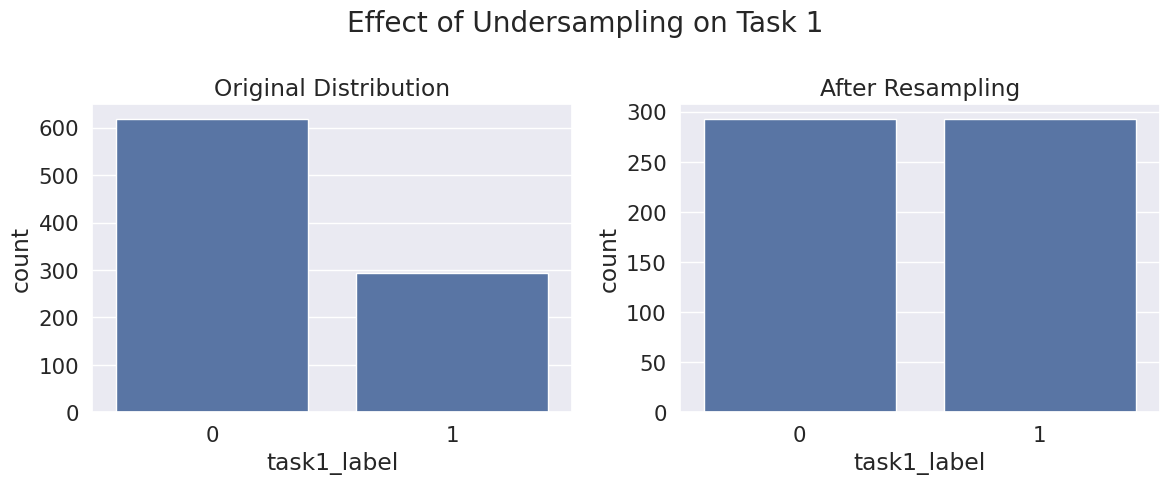

In [53]:
# Visualize effect of sampling
def plot_sampling_comparison(original_y, resampled_y, title):
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.countplot(x=original_y)
    plt.title('Original Distribution')
    
    plt.subplot(1, 2, 2)
    sns.countplot(x=resampled_y)
    plt.title('After Resampling')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Example for Task 1
plot_sampling_comparison(y_train_task1, y_train_task1_under, 'Effect of Undersampling on Task 1')

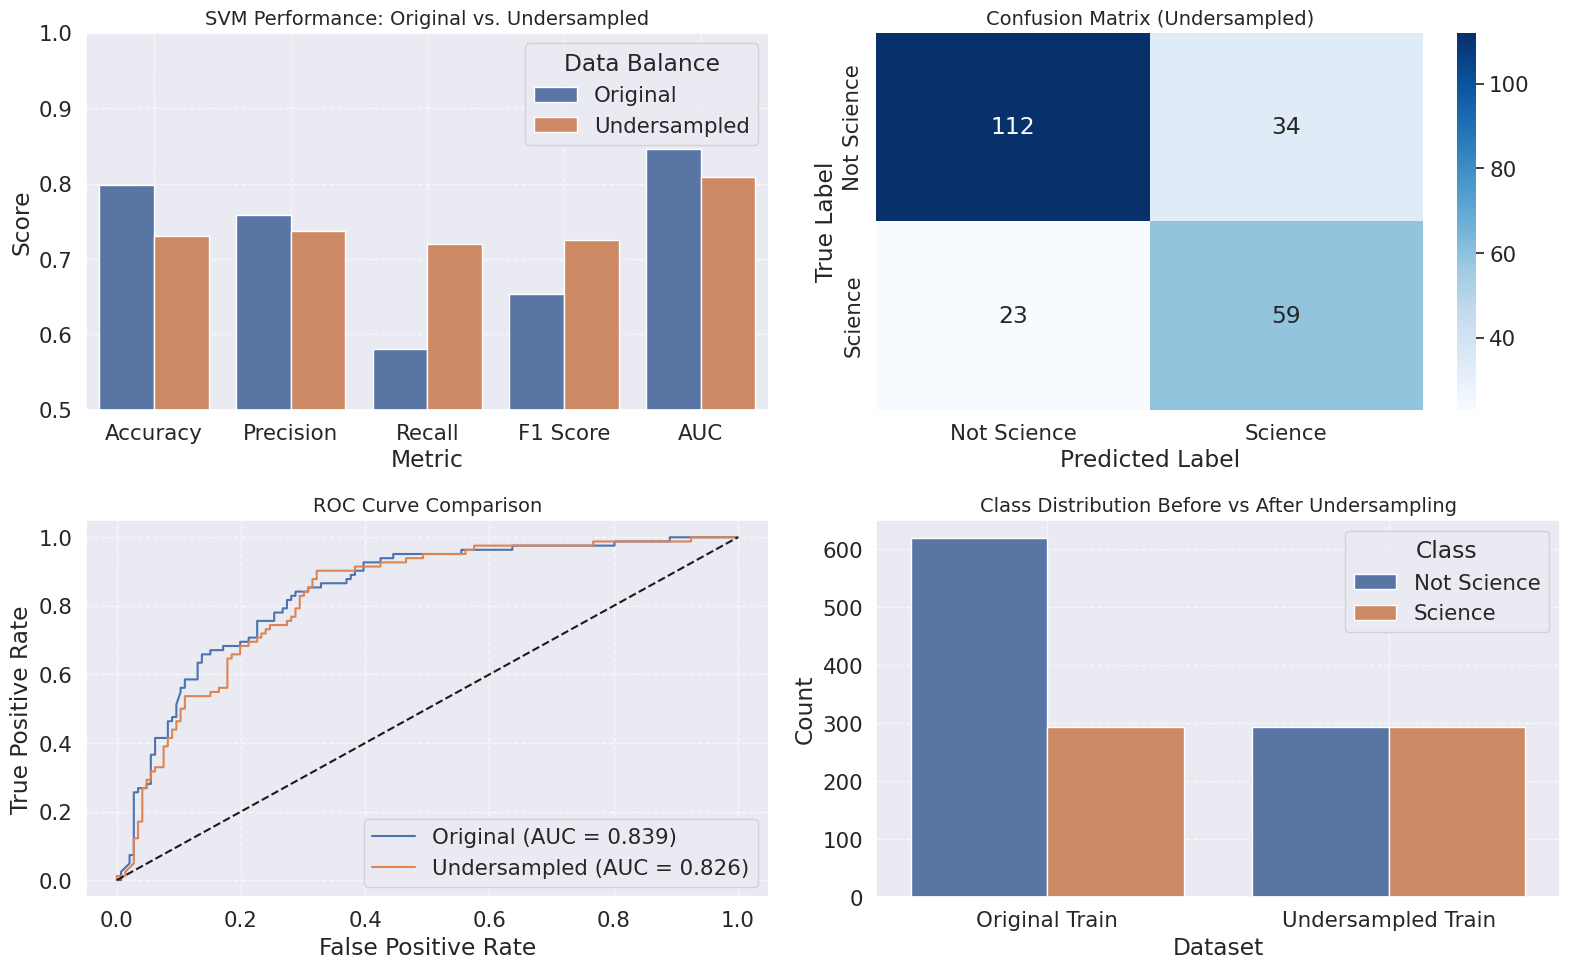


SVM Performance Comparison Summary:
           Original  Undersampled
Metric                           
Accuracy   0.798246      0.730479
Precision  0.758331      0.737308
Recall     0.581081      0.719885
F1 Score   0.653448      0.725460
AUC        0.846290      0.809265

Original Class Distribution: Counter({0: 619, 1: 293})
Undersampled Class Distribution: Counter({0: 293, 1: 293})

Relative Improvement After Undersampling:
           Improvement (%)
Metric                    
Accuracy         -8.489412
Precision        -2.772259
Recall           23.887196
F1 Score         11.020415
AUC              -4.374963


In [54]:
# Retrain the best model (SVM) with undersampled data
best_model = best_models['SVM']

# Evaluate on the original test data for fair comparison
best_model.fit(X_train_task1_under, y_train_task1_under)
y_pred_under = best_model.predict(X_test_task1)
accuracy_under = accuracy_score(y_test_task1, y_pred_under)
report_under = classification_report(y_test_task1, y_pred_under, output_dict=True)
cm_under = confusion_matrix(y_test_task1, y_pred_under)

# Perform k-fold cross validation with undersampled data
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store evaluation metrics
fold_accuracy_under = []
fold_precision_under = []
fold_recall_under = []
fold_f1_under = []
fold_auc_under = []

# Get a balanced dataset
X_balanced = X_train_task1_under
y_balanced = y_train_task1_under

# Perform cross-validation
for fold, (train_idx, test_idx) in enumerate(skf.split(X_balanced, y_balanced)):
    X_train_fold, X_test_fold = X_balanced[train_idx], X_balanced[test_idx]
    y_train_fold, y_test_fold = y_balanced.iloc[train_idx], y_balanced.iloc[test_idx]
    
    best_model.fit(X_train_fold, y_train_fold)
    y_pred_fold = best_model.predict(X_test_fold)
    
    # Calculate metrics
    acc = accuracy_score(y_test_fold, y_pred_fold)
    prec = precision_score(y_test_fold, y_pred_fold, zero_division=0)
    rec = recall_score(y_test_fold, y_pred_fold, zero_division=0)
    f1 = f1_score(y_test_fold, y_pred_fold, zero_division=0)
    
    # For AUC
    if hasattr(best_model, "predict_proba"):
        y_prob = best_model.predict_proba(X_test_fold)[:, 1]
        auc_score = roc_auc_score(y_test_fold, y_prob)
        fold_auc_under.append(auc_score)
    
    fold_accuracy_under.append(acc)
    fold_precision_under.append(prec)
    fold_recall_under.append(rec)
    fold_f1_under.append(f1)

# Compare performance metrics before and after undersampling
comparison_data = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Original': [
        best_cv_results['SVM']['accuracy']['mean'],
        best_cv_results['SVM']['precision']['mean'], 
        best_cv_results['SVM']['recall']['mean'],
        best_cv_results['SVM']['f1']['mean'],
        best_cv_results['SVM']['auc']['mean'] if 'auc' in best_cv_results['SVM'] else None
    ],
    'Undersampled': [
        np.mean(fold_accuracy_under),
        np.mean(fold_precision_under),
        np.mean(fold_recall_under),
        np.mean(fold_f1_under),
        np.mean(fold_auc_under) if fold_auc_under else None
    ]
}

comparison_df = pd.DataFrame(comparison_data)

# Create visualizations
plt.figure(figsize=(16, 10))

# Bar chart comparison
plt.subplot(2, 2, 1)
comparison_melted = pd.melt(comparison_df, id_vars=['Metric'], 
                           value_vars=['Original', 'Undersampled'],
                           var_name='Data Balance', value_name='Score')

# Filter out any None values
comparison_melted = comparison_melted.dropna()

sns.barplot(x='Metric', y='Score', hue='Data Balance', data=comparison_melted)
plt.title('SVM Performance: Original vs. Undersampled', fontsize=14)
plt.ylim(0.5, 1.0)
plt.grid(True, linestyle='--', alpha=0.7)

# Confusion matrix for undersampled model
plt.subplot(2, 2, 2)
sns.heatmap(cm_under, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Science', 'Science'],
            yticklabels=['Not Science', 'Science'])
plt.title('Confusion Matrix (Undersampled)', fontsize=14)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# ROC Curve comparison if available
if hasattr(best_model, "predict_proba"):
    plt.subplot(2, 2, 3)
    # For original model
    y_prob_orig = best_model.fit(X_train_task1, y_train_task1).predict_proba(X_test_task1)[:, 1]
    fpr_orig, tpr_orig, _ = roc_curve(y_test_task1, y_prob_orig)
    auc_orig = auc(fpr_orig, tpr_orig)
    
    # For undersampled model
    best_model.fit(X_train_task1_under, y_train_task1_under)
    y_prob_under = best_model.predict_proba(X_test_task1)[:, 1]
    fpr_under, tpr_under, _ = roc_curve(y_test_task1, y_prob_under)
    auc_under = auc(fpr_under, tpr_under)
    
    # Plot ROC curves
    plt.plot(fpr_orig, tpr_orig, label=f'Original (AUC = {auc_orig:.3f})')
    plt.plot(fpr_under, tpr_under, label=f'Undersampled (AUC = {auc_under:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve Comparison', fontsize=14)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)

# Class distribution before and after undersampling
plt.subplot(2, 2, 4)
class_dist = pd.DataFrame({
    'Dataset': ['Original Train'] * 2 + ['Undersampled Train'] * 2,
    'Class': ['Not Science', 'Science'] * 2,
    'Count': [
        sum(y_train_task1 == 0), 
        sum(y_train_task1 == 1),
        sum(y_train_task1_under == 0), 
        sum(y_train_task1_under == 1)
    ]
})
sns.barplot(x='Dataset', y='Count', hue='Class', data=class_dist)
plt.title('Class Distribution Before vs After Undersampling', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Print summary
print("\nSVM Performance Comparison Summary:")
print(comparison_df.set_index('Metric'))
print("\nOriginal Class Distribution:", Counter(y_train_task1))
print("Undersampled Class Distribution:", Counter(y_train_task1_under))

# Calculate improvement percentages
improvement_df = pd.DataFrame({
    'Metric': comparison_df['Metric'],
    'Improvement (%)': [
        ((comparison_df['Undersampled'][i] - comparison_df['Original'][i]) / comparison_df['Original'][i]) * 100 
        if comparison_df['Original'][i] is not None and comparison_df['Undersampled'][i] is not None
        else None
        for i in range(len(comparison_df))
    ]
})
print("\nRelative Improvement After Undersampling:")
print(improvement_df.set_index('Metric'))

In [56]:
# TASK 2: Scientific Claim/Reference Classification

# Since Task 2 is only applicable to science-related tweets, we need to use the science-related subset
print("Task 2: Scientific Claim/Reference Classification\n" + "="*50)

# Get a dense version of features for science-related tweets
# Convert the pandas Series to a numpy array with .values
X_dense_sci = X_selected[(df['science_related'] == 1).values].toarray()
y_task2 = df_sci['task2_label']

# Split data for Task 2
X_train_task2, X_test_task2, y_train_task2, y_test_task2 = train_test_split(
    X_dense_sci, y_task2, test_size=0.2, random_state=42
)

# Define the best models from Task 1 (you can modify these based on Task 1 results)
task2_models = {
    'Gaussian NB': GaussianNB(var_smoothing=0.0152),
    'Multinomial NB': MultinomialNB(alpha=0.4641, fit_prior=True),
    'Complement NB': ComplementNB(alpha=2.8480, fit_prior=True),
    'Bernoulli NB': BernoulliNB(alpha=0.17475, fit_prior=True),
    'KNN': KNeighborsClassifier(n_neighbors=7, weights='uniform', metric='euclidean'),
    'SVM': SVC(C=1.4174742, kernel='rbf', gamma='scale', probability=True),
    'Logistic Regression': LogisticRegression(C=np.float64(4.328761281083062), penalty='l1', solver='saga', max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=None, min_samples_split=5, min_samples_leaf=1)
}

# Train and evaluate models for Task 2
task2_results = {}
for name, model in task2_models.items():
    task2_results[name] = evaluate_model(
        model, X_train_task2, X_test_task2, y_train_task2, y_test_task2, name
    )
    print("\n")

Task 2: Scientific Claim/Reference Classification
Model: Gaussian NB
Accuracy: 0.8533
              precision    recall  f1-score   support

           0       0.30      0.43      0.35         7
           1       0.94      0.90      0.92        68

    accuracy                           0.85        75
   macro avg       0.62      0.66      0.64        75
weighted avg       0.88      0.85      0.86        75



Model: Multinomial NB
Accuracy: 0.9067
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.91      1.00      0.95        68

    accuracy                           0.91        75
   macro avg       0.45      0.50      0.48        75
weighted avg       0.82      0.91      0.86        75



Model: Complement NB
Accuracy: 0.7200
              precision    recall  f1-score   support

           0       0.18      0.57      0.28         7
           1       0.94      0.74      0.83        68

    accuracy   

/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

Model: SVM
Accuracy: 0.9200
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.92      1.00      0.96        68

    accuracy                           0.92        75
   macro avg       0.96      0.57      0.60        75
weighted avg       0.93      0.92      0.89        75



Model: Logistic Regression
Accuracy: 0.9200
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.92      1.00      0.96        68

    accuracy                           0.92        75
   macro avg       0.96      0.57      0.60        75
weighted avg       0.93      0.92      0.89        75



Model: Random Forest
Accuracy: 0.9200
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.92      1.00      0.96        68

    accuracy                           0.92        75
   macro avg  

In [57]:
# Cross-validation for Task 2
print("Task 2: Cross-Validation\n" + "="*40)

# Initialize k-fold cross validation
k_folds = 10
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

# Dictionary to store CV results
task2_cv_results = {}

# Perform k-fold cross validation for each model
for model_name, model in task2_models.items():
    print(f"Performing {k_folds}-fold cross-validation for {model_name}...")
    
    # Initialize lists to store performance metrics for each fold
    fold_accuracy = []
    fold_precision = []
    fold_recall = []
    fold_f1 = []
    fold_auc = []
    
    # For each fold
    for fold, (train_idx, test_idx) in enumerate(skf.split(X_dense_sci, y_task2)):
        # Split data
        X_train_fold, X_test_fold = X_dense_sci[train_idx], X_dense_sci[test_idx]
        y_train_fold, y_test_fold = y_task2.iloc[train_idx], y_task2.iloc[test_idx]
        
        # Train model
        model.fit(X_train_fold, y_train_fold)
        
        # Make predictions
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate metrics
        acc = accuracy_score(y_test_fold, y_pred_fold)
        prec = precision_score(y_test_fold, y_pred_fold, zero_division=0)
        rec = recall_score(y_test_fold, y_pred_fold, zero_division=0)
        f1 = f1_score(y_test_fold, y_pred_fold, zero_division=0)
        
        # For AUC, we need probability estimates
        try:
            if hasattr(model, "predict_proba"):
                y_prob = model.predict_proba(X_test_fold)[:, 1]
                auc_score = roc_auc_score(y_test_fold, y_prob)
                fold_auc.append(auc_score)
        except:
            pass
        
        fold_accuracy.append(acc)
        fold_precision.append(prec)
        fold_recall.append(rec)
        fold_f1.append(f1)
    
    # Store average metrics and standard deviations
    task2_cv_results[model_name] = {
        'accuracy': {
            'mean': np.mean(fold_accuracy),
            'std': np.std(fold_accuracy)
        },
        'precision': {
            'mean': np.mean(fold_precision),
            'std': np.std(fold_precision)
        },
        'recall': {
            'mean': np.mean(fold_recall),
            'std': np.std(fold_recall)
        },
        'f1': {
            'mean': np.mean(fold_f1),
            'std': np.std(fold_f1)
        }
    }
    
    if fold_auc:
        task2_cv_results[model_name]['auc'] = {
            'mean': np.mean(fold_auc),
            'std': np.std(fold_auc)
        }
        print(f"  Average: AUC={task2_cv_results[model_name]['auc']['mean']:.4f} ± {task2_cv_results[model_name]['auc']['std']:.4f}")
    
    print(f"  Average: Accuracy={task2_cv_results[model_name]['accuracy']['mean']:.4f} ± {task2_cv_results[model_name]['accuracy']['std']:.4f}")
    print(f"  Average: F1 Score={task2_cv_results[model_name]['f1']['mean']:.4f} ± {task2_cv_results[model_name]['f1']['std']:.4f}")
    print()

Task 2: Cross-Validation
Performing 10-fold cross-validation for Gaussian NB...
  Average: AUC=0.5660 ± 0.1187
  Average: Accuracy=0.8217 ± 0.0635
  Average: F1 Score=0.8988 ± 0.0375

Performing 10-fold cross-validation for Multinomial NB...
  Average: AUC=0.7806 ± 0.0932
  Average: Accuracy=0.9148 ± 0.0152
  Average: F1 Score=0.9554 ± 0.0081

Performing 10-fold cross-validation for Complement NB...
  Average: AUC=0.7468 ± 0.0979
  Average: Accuracy=0.7151 ± 0.0768
  Average: F1 Score=0.8205 ± 0.0532

Performing 10-fold cross-validation for Bernoulli NB...
  Average: AUC=0.7860 ± 0.0991
  Average: Accuracy=0.8935 ± 0.0332
  Average: F1 Score=0.9423 ± 0.0184

Performing 10-fold cross-validation for KNN...
  Average: AUC=0.5324 ± 0.0660
  Average: Accuracy=0.9094 ± 0.0126
  Average: F1 Score=0.9525 ± 0.0069

Performing 10-fold cross-validation for SVM...
  Average: AUC=0.7151 ± 0.1219
  Average: Accuracy=0.9175 ± 0.0179
  Average: F1 Score=0.9567 ± 0.0095

Performing 10-fold cross-valida

/home/hurel/Documents/repo/projet-ml/.venv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


  Average: AUC=0.7019 ± 0.1686
  Average: Accuracy=0.9068 ± 0.0242
  Average: F1 Score=0.9503 ± 0.0131

Performing 10-fold cross-validation for Random Forest...
  Average: AUC=0.7260 ± 0.1391
  Average: Accuracy=0.9148 ± 0.0152
  Average: F1 Score=0.9554 ± 0.0081



/tmp/ipykernel_368067/1744879752.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


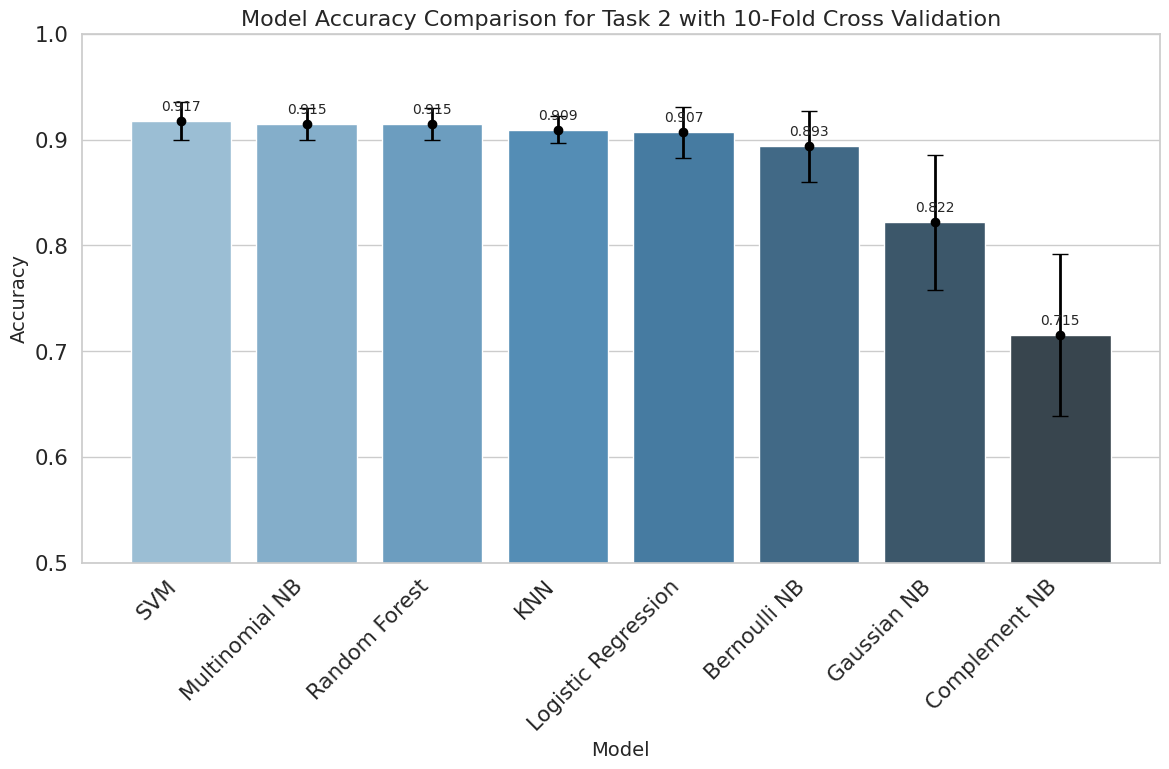

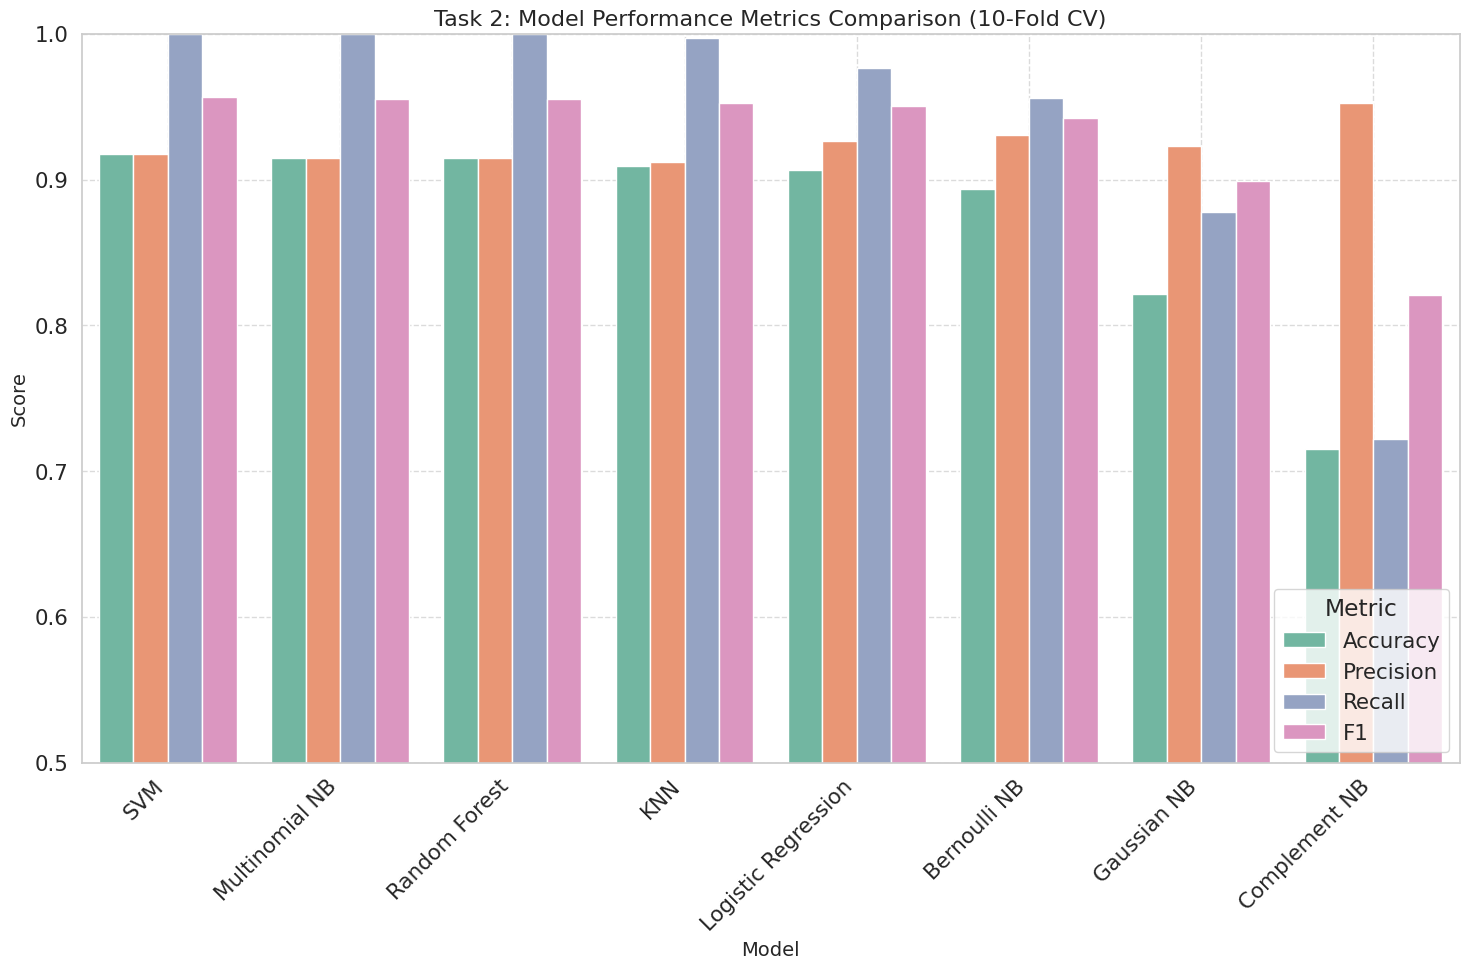

In [58]:
# Visualize Task 2 cross-validation results
# Create DataFrame for visualization
task2_results_df = pd.DataFrame({
    'Model': [],
    'Metric': [],
    'Mean': [],
    'Std': []
})

for model_name in task2_cv_results:
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        task2_results_df = pd.concat([task2_results_df, pd.DataFrame({
            'Model': [model_name],
            'Metric': [metric.capitalize()],
            'Mean': [task2_cv_results[model_name][metric]['mean']],
            'Std': [task2_cv_results[model_name][metric]['std']]
        })], ignore_index=True)
    if 'auc' in task2_cv_results[model_name]:
        task2_results_df = pd.concat([task2_results_df, pd.DataFrame({
            'Model': [model_name],
            'Metric': ['AUC'],
            'Mean': [task2_cv_results[model_name]['auc']['mean']],
            'Std': [task2_cv_results[model_name]['auc']['std']]
        })], ignore_index=True)

# Sort models by accuracy
task2_model_order = task2_results_df[task2_results_df['Metric'] == 'Accuracy'].sort_values('Mean', ascending=False)['Model'].tolist()

# Create accuracy bar plot
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")

# Create bar plot for accuracy
ax = sns.barplot(
    data=task2_results_df[task2_results_df['Metric'] == 'Accuracy'],
    x='Model',
    y='Mean',
    order=task2_model_order,
    palette='Blues_d'
)

# Add error bars
for i, model in enumerate(task2_model_order):
    row = task2_results_df[(task2_results_df['Model'] == model) & (task2_results_df['Metric'] == 'Accuracy')].iloc[0]
    ax.errorbar(
        i, row['Mean'], yerr=row['Std'],
        fmt='o', color='black', elinewidth=2, capsize=6
    )

# Add value labels on top of bars
for i, bar in enumerate(ax.patches):
    ax.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 0.01,
        f"{bar.get_height():.3f}",
        ha='center',
        fontsize=10
    )

plt.title(f'Model Accuracy Comparison for Task 2 with {k_folds}-Fold Cross Validation', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim([0.5, 1.0])
plt.tight_layout()
plt.show()

# Create a grouped bar chart for all metrics
plt.figure(figsize=(15, 10))
sns.set_style("whitegrid")

# Create grouped bar plot
ax = sns.barplot(
    data=task2_results_df[task2_results_df['Metric'] != 'AUC'],
    x='Model',
    y='Mean',
    hue='Metric',
    order=task2_model_order,
    palette='Set2'
)

plt.title(f'Task 2: Model Performance Metrics Comparison ({k_folds}-Fold CV)', fontsize=16)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', loc='lower right')
plt.ylim([0.5, 1.0])
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Performing Grid Search for SVM on Task 2...
Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best Parameters: {'C': np.float64(215.44346900318823), 'gamma': 'auto', 'kernel': 'rbf'}
Best Cross-Validation Score: 0.9167
Test Accuracy with Best Parameters: 0.9200

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.92      1.00      0.96        68

    accuracy                           0.92        75
   macro avg       0.96      0.57      0.60        75
weighted avg       0.93      0.92      0.89        75



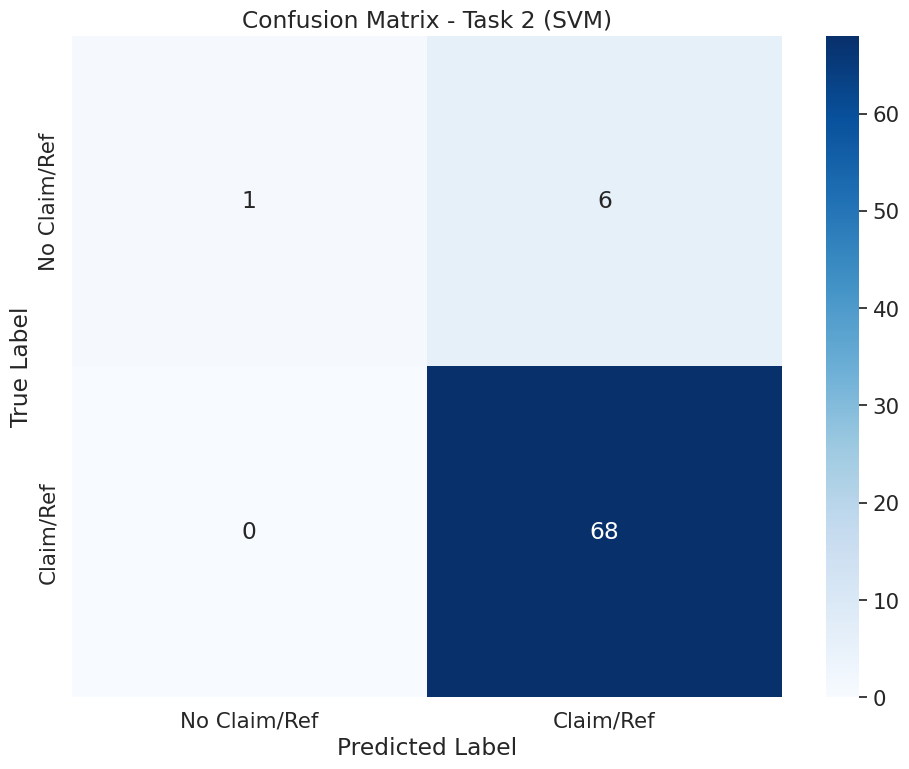

In [59]:
# Hyperparameter optimization for the best model on Task 2
# Let's assume SVM was the best model (update based on your results)
best_task2_model_name = 'SVM'  # Replace with the actual best model from your results
best_task2_model = task2_models[best_task2_model_name]

print(f"Performing Grid Search for {best_task2_model_name} on Task 2...")

# Define the parameter grid for the best model
if best_task2_model_name == 'SVM':
    param_grid = {
        'C': np.logspace(-3, 3, 10),
        'gamma': ['scale', 'auto'] + list(np.logspace(-3, 3, 5)),
        'kernel': ['rbf', 'linear']
    }
elif best_task2_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
elif best_task2_model_name.endswith('NB'):
    if best_task2_model_name == 'Gaussian NB':
        param_grid = {
            'var_smoothing': np.logspace(-10, 0, 11)
        }
    else:
        param_grid = {
            'alpha': np.logspace(-3, 3, 10),
            'fit_prior': [True, False]
        }
else:
    # Default grid for other models
    param_grid = {
        'C': np.logspace(-3, 3, 10)
    }

# Create and fit GridSearchCV
grid_search_task2 = GridSearchCV(
    estimator=best_task2_model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

grid_search_task2.fit(X_train_task2, y_train_task2)

# Display the best parameters and score
print(f"Best Parameters: {grid_search_task2.best_params_}")
print(f"Best Cross-Validation Score: {grid_search_task2.best_score_:.4f}")

# Evaluate on test set
best_model_task2 = grid_search_task2.best_estimator_
y_pred_task2 = best_model_task2.predict(X_test_task2)
accuracy_task2 = accuracy_score(y_test_task2, y_pred_task2)
print(f"Test Accuracy with Best Parameters: {accuracy_task2:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_task2, y_pred_task2))

# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_task2, y_pred_task2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Claim/Ref', 'Claim/Ref'],
            yticklabels=['No Claim/Ref', 'Claim/Ref'])
plt.title(f'Confusion Matrix - Task 2 ({best_task2_model_name})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [60]:
# Check for class imbalance in Task 2
print("Task 2 class distribution:")
print(y_task2.value_counts())
print(y_task2.value_counts(normalize=True).round(3) * 100, '%')

# Apply class balancing for Task 2 if needed
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Let's try SMOTE for handling imbalance
smote = SMOTE(random_state=42)
X_train_task2_balanced, y_train_task2_balanced = smote.fit_resample(X_train_task2, y_train_task2)

print("\nClass distribution after SMOTE balancing:")
print(pd.Series(y_train_task2_balanced).value_counts())

# Train the best model with balanced data
best_model_balanced = clone(best_model_task2)
best_model_balanced.fit(X_train_task2_balanced, y_train_task2_balanced)

# Evaluate on the test set
y_pred_balanced = best_model_balanced.predict(X_test_task2)
accuracy_balanced = accuracy_score(y_test_task2, y_pred_balanced)
print(f"\nTest Accuracy with Balanced Training Data: {accuracy_balanced:.4f}")
print("\nClassification Report with Balanced Training Data:")
print(classification_report(y_test_task2, y_pred_balanced))

# Compare balanced vs unbalanced training
plt.figure(figsize=(12, 6))
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
unbalanced_scores = [
    accuracy_task2,
    precision_score(y_test_task2, y_pred_task2),
    recall_score(y_test_task2, y_pred_task2),
    f1_score(y_test_task2, y_pred_task2)
]
balanced_scores = [
    accuracy_balanced,
    precision_score(y_test_task2, y_pred_balanced),
    recall_score(y_test_task2, y_pred_balanced),
    f1_score(y_test_task2, y_pred_balanced)
]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, unbalanced_scores, width, label='Unbalanced Training')
plt.bar(x + width/2, balanced_scores, width, label='Balanced Training')
plt.xticks(x, metrics)
plt.ylabel('Score')
plt.title('Impact of Class Balancing on Task 2 Performance')
plt.legend()
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

Task 2 class distribution:
task2_label
1    342
0     33
Name: count, dtype: int64
task2_label
1    91.2
0     8.8
Name: proportion, dtype: float64 %

Class distribution after SMOTE balancing:
task2_label
1    274
0    274
Name: count, dtype: int64


NameError: name 'clone' is not defined